# NYPD COLLISION DATA ANALYSIS - BROOKLYN

#### NYPD public collision data, ~1M records spanning mid 2012 through early 2017. This is an EDA focusing on generating insights from the Brooklyn data

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
# seaborn also builds on matplotlib and adds graphical features and new plot types
import seaborn as sns
import datetime;

In [99]:
data = pd.read_csv('~/Downloads/NYPD_Motor_Vehicle_Collisions.csv')

In [100]:
#Some null values - some are likely due to data availablity rather than just not recorded 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985613 entries, 0 to 985612
Data columns (total 29 columns):
DATE                             985613 non-null object
TIME                             985613 non-null object
BOROUGH                          726743 non-null object
ZIP CODE                         726643 non-null float64
LATITUDE                         784396 non-null float64
LONGITUDE                        784396 non-null float64
LOCATION                         784396 non-null object
ON STREET NAME                   799247 non-null object
CROSS STREET NAME                770631 non-null object
OFF STREET NAME                  72775 non-null object
NUMBER OF PERSONS INJURED        985613 non-null int64
NUMBER OF PERSONS KILLED         985613 non-null int64
NUMBER OF PEDESTRIANS INJURED    985613 non-null int64
NUMBER OF PEDESTRIANS KILLED     985613 non-null int64
NUMBER OF CYCLIST INJURED        985613 non-null int64
NUMBER OF CYCLIST KILLED         985613 non-null int

In [101]:
#making all cols visible from this point onward
pd.set_option('display.max_columns', 500)
data.head()

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,11/17/2016,16:11,BROOKLYN,11236.0,40.645032,-73.919978,"(40.6450318, -73.9199775)",RALPH AVENUE,CLARENDON ROAD,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3568080,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN
1,11/17/2016,16:11,MANHATTAN,10022.0,40.755130,-73.965241,"(40.7551305, -73.9652411)",1 AVENUE,EAST 52 STREET,NaN,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,3562471,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN
2,11/17/2016,16:11,MANHATTAN,10172.0,40.755300,-73.975344,"(40.7553005, -73.9753439)",EAST 47 STREET,PARK AVENUE,NaN,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,3562967,PASSENGER VEHICLE,TAXI,NaN,NaN,NaN
3,11/17/2016,16:11,QUEENS,11358.0,40.757325,-73.783163,"(40.7573251, -73.7831629)",FRANCIS LEWIS BOULEVARD,44 AVENUE,NaN,0,0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,3562576,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
4,11/17/2016,16:11,NaN,NaN,40.692726,-73.726718,"(40.6927264, -73.726718)",NaN,NaN,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3562402,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN


### Some things I see off the bat...                                                                                                                                           

### -I probably need to create a column of datetime objects to do any analysis that slices the data by time                  

### -The longitude/latitude data might help identify problem areas (eg. bad visibility of stop signs), but could be a pain to cluster since I'll need to figure out the appropriate precision (cluster size/precision tradeoff. Zipcode, on the other hand, is probably not precise enough.  A good proxy for location of the collision might be closest intersection, which we can create by just concatenating the 'ON STREET NAME' var with 'CROSS STREET NAME.'                                    

### -There are a ton of sparce columns about severity of the collision (persons/pedestrians/cyclists/motorists, killed v injured).  It might make sense to merge some of these.  Bucking collisions as either 'serious' and 'not serious' might be a good approach for now. 'Serious' can be defined as any collision where someone is injured or killed. 


In [102]:
#creating a new column of datetime data and removing the original date and time cols
data['DATE_TIME'] = data['DATE'] + ' ' + data['TIME']
data.drop(['DATE','TIME'], axis=1, inplace=True)
data['DATE'] = pd.to_datetime(data['DATE_TIME'], format = '%m/%d/%Y %H:%M')

In [103]:
#creating a new column to capture closest intersection of the collision
data['INTERSECTION'] = data['ON STREET NAME'] + ' AT ' + data['CROSS STREET NAME']

In [104]:
#creating columns to identify whether collision is 'serious' or not
data['SUM_SERIOUS_COL'] = data['NUMBER OF PERSONS INJURED'] + data['NUMBER OF PERSONS KILLED'] + data['NUMBER OF PEDESTRIANS INJURED'] + data['NUMBER OF PEDESTRIANS KILLED'] + data['NUMBER OF CYCLIST INJURED'] + data['NUMBER OF CYCLIST KILLED'] + data['NUMBER OF MOTORIST INJURED'] + data['NUMBER OF MOTORIST KILLED']
data['COLLISION_SERIOUS'] = np.where(data['SUM_SERIOUS_COL']>0, 1, 0)
data['COLLISION'] = 1
data['COLLISION_NOT_SERIOUS'] = data['COLLISION'] - data['COLLISION_SERIOUS']

In [105]:
#check whether these new cols look ok
data.head()

,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,DATE_TIME,DATE,INTERSECTION,SUM_SERIOUS_COL,COLLISION_SERIOUS,COLLISION,COLLISION_NOT_SERIOUS
0,BROOKLYN,11236.0,40.645032,-73.919978,"(40.6450318, -73.9199775)",RALPH AVENUE,CLARENDON ROAD,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3568080,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,11/17/2016 16:11,2016-11-17 16:11:00,RALPH AVENUE AT CLARENDON ROAD,0,0,1,1
1,MANHATTAN,10022.0,40.755130,-73.965241,"(40.7551305, -73.9652411)",1 AVENUE,EAST 52 STREET,NaN,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,3562471,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN,11/17/2016 16:11,2016-11-17 16:11:00,1 AVENUE AT EAST 52 STREET,0,0,1,1
2,MANHATTAN,10172.0,40.755300,-73.975344,"(40.7553005, -73.9753439)",EAST 47 STREET,PARK AVENUE,NaN,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,3562967,PASSENGER VEHICLE,TAXI,NaN,NaN,NaN,11/17/2016 16:11,2016-11-17 16:11:00,EAST 47 STREET AT PARK AVENUE,0,0,1,1
3,QUEENS,11358.0,40.757325,-73.783163,"(40.7573251, -73.7831629)",FRANCIS LEWIS BOULEVARD,44 AVENUE,NaN,0,0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,3562576,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,11/17/2016 16:11,2016-11-17 16:11:00,FRANCIS LEWIS BOULEVARD AT 44 AVENUE,0,0,1,1
4,NaN,NaN,40.692726,-73.726718,"(40.6927264, -73.726718)",NaN,NaN,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3562402,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,11/17/2016 16:11,2016-11-17 16:11:00,NaN,0,0,1,1


In [106]:
print 'Total Collions: ', data['COLLISION'].sum()
print 'Total Serious Collions: ', data['COLLISION_SERIOUS'].sum()
print 'Total Collions - Not Serious: ', data['COLLISION_NOT_SERIOUS'].sum()
print 'Check sum: ', (data['COLLISION_SERIOUS'].sum() + data['COLLISION_NOT_SERIOUS'].sum())
print 'Pct Serious: ', float(data['COLLISION_SERIOUS'].sum())/data['COLLISION'].sum()

Total Collions:  985613
Total Serious Collions:  184979
Total Collions - Not Serious:  800634
Check sum:  985613
Pct Serious:  0.187679139784


### We can now start with some initial analysis.  First, I'll create a new dataframe limiting the data to Brooklyn

In [107]:
brooklyn = data[data['BOROUGH']=='BROOKLYN']

In [108]:
brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222591 entries, 0 to 985609
Data columns (total 34 columns):
BOROUGH                          222591 non-null object
ZIP CODE                         222587 non-null float64
LATITUDE                         213792 non-null float64
LONGITUDE                        213792 non-null float64
LOCATION                         213792 non-null object
ON STREET NAME                   207336 non-null object
CROSS STREET NAME                207336 non-null object
OFF STREET NAME                  15231 non-null object
NUMBER OF PERSONS INJURED        222591 non-null int64
NUMBER OF PERSONS KILLED         222591 non-null int64
NUMBER OF PEDESTRIANS INJURED    222591 non-null int64
NUMBER OF PEDESTRIANS KILLED     222591 non-null int64
NUMBER OF CYCLIST INJURED        222591 non-null int64
NUMBER OF CYCLIST KILLED         222591 non-null int64
NUMBER OF MOTORIST INJURED       222591 non-null int64
NUMBER OF MOTORIST KILLED        222591 non-null int64

In [109]:
print 'Total Collions: ', brooklyn['COLLISION'].sum()
print 'Total Serious Collions: ', brooklyn['COLLISION_SERIOUS'].sum()
print 'Total Collions - Not Serious: ', brooklyn['COLLISION_NOT_SERIOUS'].sum()
print 'Check sum: ', (brooklyn['COLLISION_SERIOUS'].sum() + brooklyn['COLLISION_NOT_SERIOUS'].sum())
print 'Pct Serious: ', float(brooklyn['COLLISION_SERIOUS'].sum())/brooklyn['COLLISION'].sum()

Total Collions:  222591
Total Serious Collions:  48536
Total Collions - Not Serious:  174055
Check sum:  222591
Pct Serious:  0.218050145783


### -working with about 223K total collision records, 49K of which are serious.  22% pct serious is higher than the NYC overall pct

### -it seems pretty obvious that there is going to be some high time-of-day/day-of-week variability in collision volume, so I'll start here. 

### -the datetime object we created needs to be parsed to get day of week and time.  For time, hour is probably the most workable unit so I'll pull this data into new columns. 

In [110]:
#new col for day-of-week names, day-of-week number (for ordering in visualizations later), and hour
brooklyn['DAY_OF_WEEK'] = brooklyn['DATE'].dt.weekday_name
brooklyn['DOW'] = brooklyn['DATE'].dt.dayofweek
brooklyn['HOUR'] = brooklyn['DATE'].dt.hour



/Users/mdcorey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mdcorey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/mdcorey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [111]:
#confirming that this worked...
brooklyn.head()

,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,DATE_TIME,DATE,INTERSECTION,SUM_SERIOUS_COL,COLLISION_SERIOUS,COLLISION,COLLISION_NOT_SERIOUS,DAY_OF_WEEK,DOW,HOUR
0,BROOKLYN,11236.0,40.645032,-73.919978,"(40.6450318, -73.9199775)",RALPH AVENUE,CLARENDON ROAD,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3568080,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,11/17/2016 16:11,2016-11-17 16:11:00,RALPH AVENUE AT CLARENDON ROAD,0,0,1,1,Thursday,3,16
11,BROOKLYN,11220.0,40.632464,-74.009119,"(40.6324635, -74.0091187)",63 STREET,9 AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3562013,SPORT UTILITY / STATION WAGON,VAN,NaN,NaN,NaN,11/15/2016 8:11,2016-11-15 08:11:00,63 STREET AT 9 AVENUE,0,0,1,1,Tuesday,1,8
15,BROOKLYN,11212.0,40.660739,-73.910378,"(40.6607386, -73.9103783)",BRISTOL STREET,RIVERDALE AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3432357,PASSENGER VEHICLE,BICYCLE,NaN,NaN,NaN,04/27/2016 16:00,2016-04-27 16:00:00,BRISTOL STREET AT RIVERDALE AVENUE,0,0,1,1,Wednesday,2,16
22,BROOKLYN,11212.0,40.667096,-73.922752,"(40.6670963, -73.9227518)",RALPH AVENUE,EAST NEW YORK AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3432353,MOTORCYCLE,NaN,NaN,NaN,NaN,04/27/2016 16:25,2016-04-27 16:25:00,RALPH AVENUE AT EAST NEW YORK AVENUE,0,0,1,1,Wednesday,2,16
24,BROOKLYN,11221.0,40.695134,-73.930696,"(40.6951337, -73.9306963)",NaN,NaN,14 LAWTON STREET,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3435122,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,04/27/2016 16:40,2016-04-27 16:40:00,NaN,0,0,1,1,Wednesday,2,16


In [112]:
#Checking out the date range we are working with
print 'Max Date: ', brooklyn['DATE'].max()
print 'Min Date: ', brooklyn['DATE'].min()

Max Date:  2017-02-24 23:15:00
Min Date:  2012-07-01 00:10:00


### -We have full year data for 2013,14,15,and 16.  Partial data for 2012 and 17

In [113]:
#looking at the distribution of collisions by hour and day-of-week
pd.crosstab(brooklyn['DAY_OF_WEEK'],brooklyn['HOUR'])

HOUR,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
DAY_OF_WEEK,,,,,,,,,,,,,,,,,,,,,,,,
Friday,717,413,310,223,249,299,607,902,2124,2118,1905,1860,2071,2241,2527,2176,2613,2483,2115,1761,1493,1241,1098,941
Monday,665,363,243,199,253,303,662,1014,2221,2214,1959,1903,1973,2070,2264,2239,2671,2548,2117,1661,1375,1030,873,671
Saturday,932,700,570,511,626,521,477,485,869,1084,1231,1424,1617,1718,1909,1810,2008,1844,1715,1449,1388,1213,1197,1029
Sunday,992,829,688,603,696,644,501,394,750,861,1106,1329,1489,1695,1854,1740,1877,1683,1582,1315,1206,1067,956,731
Thursday,637,322,227,164,197,287,594,941,2161,2180,1905,1961,1968,2117,2272,2095,2543,2532,2160,1734,1402,1154,1013,716
Tuesday,584,326,226,162,167,248,611,1017,2185,2332,2021,1952,1979,2163,2279,2091,2602,2620,2288,1691,1434,1093,912,669
Wednesday,586,305,232,163,196,256,607,977,2130,2020,1801,1758,1925,2000,2329,2098,2563,2544,2260,1757,1476,1144,959,678


### It's not easy to visualize in this format but a heatmap could work well here

In [114]:
#Creating a new dataframe to build the heatmap. Grouping the data by day-of-week and hour and couting collisions
dow_time = brooklyn.groupby(['DOW','HOUR']).COLLISION.count()

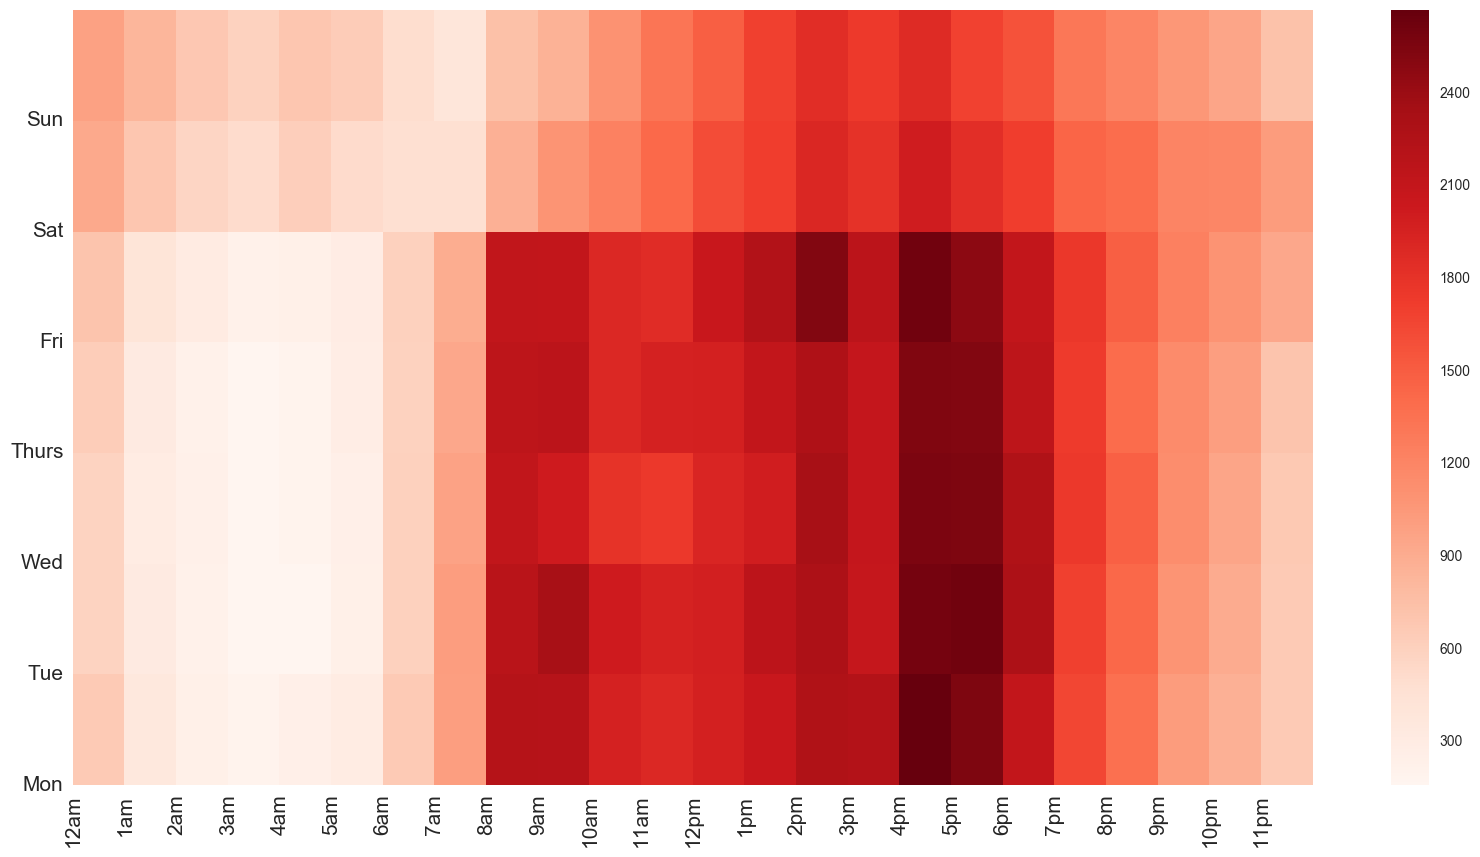

In [115]:
#heatmap
dow_time_vals = dow_time.values
test=dow_time.reshape(7,24)
fig, ax = plt.subplots(figsize=(20, 10))
heatmap = ax.pcolor(test,cmap=plt.cm.Reds)
ax.set_xticklabels(['12am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm'
                    ,'1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm'])
ax.set_yticklabels(['Mon','Tue','Wed','Thurs','Fri','Sat','Sun'])
ax.locator_params(nbins=24, axis='x')
ax.locator_params(nbins=7, axis='y')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=90)
cbar = plt.colorbar(heatmap)

### -We can see here that there is high collision volume between Mon-Fri during work and commute hours, which is intuitive.

### -The evening commute hours ~4pm-7pm are particularly problematic. Volume is also quite high 8am to 10am on weekdays 

### -Weekend collisions are highest in mid afternoon to early evening. 

### We'll do the same thing while filtering for serious collisions...

In [116]:
#Creating a new dataframe to build the heatmap. Grouping the data by day-of-week and hour and couting collisions
dow_time_serious = brooklyn.groupby(['DOW','HOUR']).COLLISION_SERIOUS.sum()

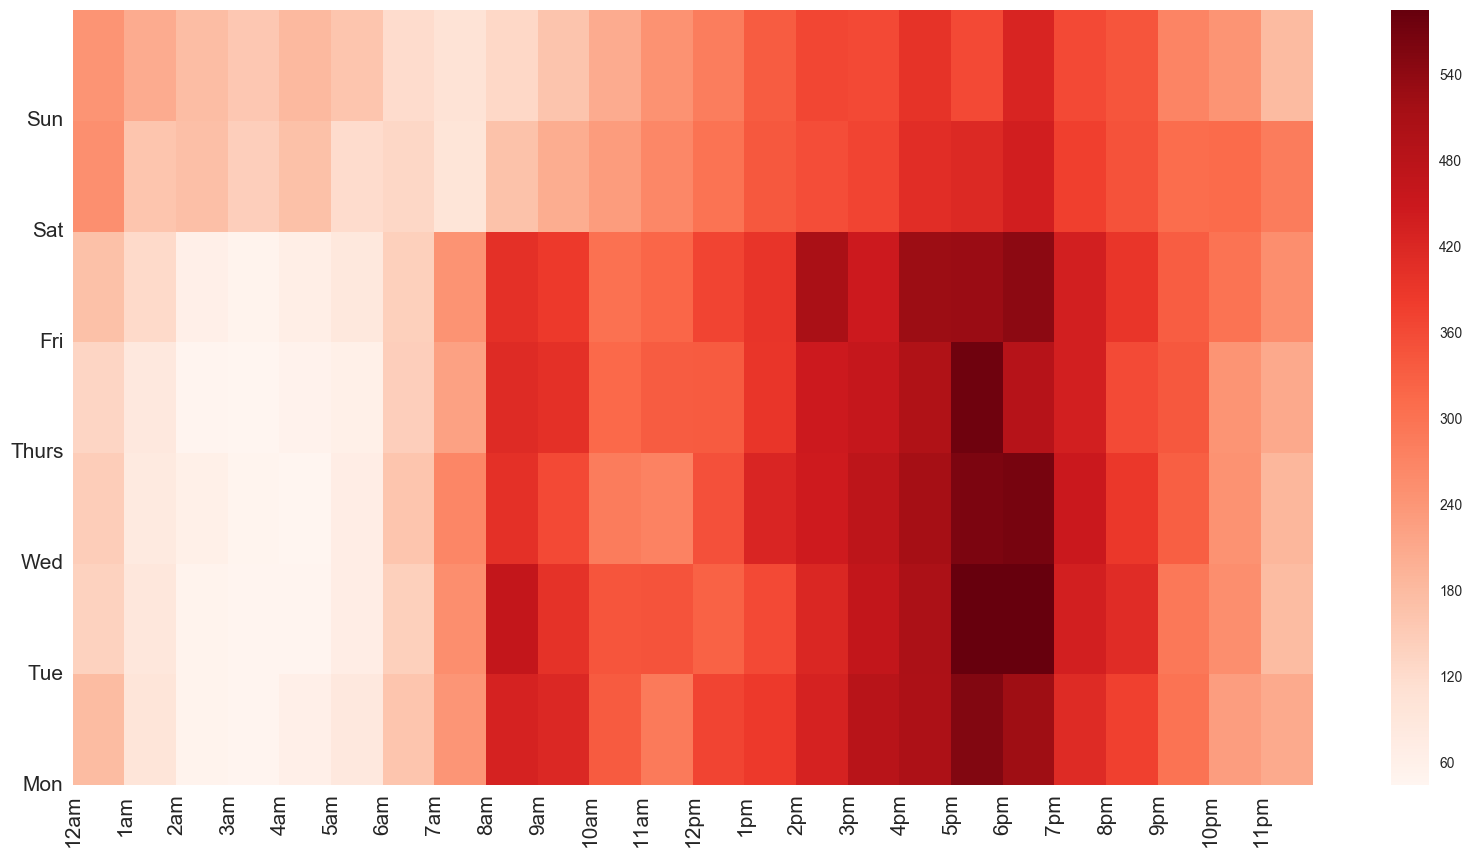

In [117]:
#heatmap
dow_time_vals = dow_time_serious.values
test=dow_time_serious.reshape(7,24)
fig, ax = plt.subplots(figsize=(20, 10))
heatmap = ax.pcolor(test,cmap=plt.cm.Reds)
ax.set_xticklabels(['12am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm'
                    ,'1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm'])
ax.set_yticklabels(['Mon','Tue','Wed','Thurs','Fri','Sat','Sun'])
ax.locator_params(nbins=24, axis='x')
ax.locator_params(nbins=7, axis='y')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=90)
cbar = plt.colorbar(heatmap)

### Not substantially different, but less concentration of serious collisions in the morning commute hours and more in the evening commute, specifically 5pm-7pm

### Next, I'll take a look at driver contributing factors.

In [118]:
#a quick look at the data again...
brooklyn.head()

,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,DATE_TIME,DATE,INTERSECTION,SUM_SERIOUS_COL,COLLISION_SERIOUS,COLLISION,COLLISION_NOT_SERIOUS,DAY_OF_WEEK,DOW,HOUR
0,BROOKLYN,11236.0,40.645032,-73.919978,"(40.6450318, -73.9199775)",RALPH AVENUE,CLARENDON ROAD,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3568080,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,11/17/2016 16:11,2016-11-17 16:11:00,RALPH AVENUE AT CLARENDON ROAD,0,0,1,1,Thursday,3,16
11,BROOKLYN,11220.0,40.632464,-74.009119,"(40.6324635, -74.0091187)",63 STREET,9 AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3562013,SPORT UTILITY / STATION WAGON,VAN,NaN,NaN,NaN,11/15/2016 8:11,2016-11-15 08:11:00,63 STREET AT 9 AVENUE,0,0,1,1,Tuesday,1,8
15,BROOKLYN,11212.0,40.660739,-73.910378,"(40.6607386, -73.9103783)",BRISTOL STREET,RIVERDALE AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3432357,PASSENGER VEHICLE,BICYCLE,NaN,NaN,NaN,04/27/2016 16:00,2016-04-27 16:00:00,BRISTOL STREET AT RIVERDALE AVENUE,0,0,1,1,Wednesday,2,16
22,BROOKLYN,11212.0,40.667096,-73.922752,"(40.6670963, -73.9227518)",RALPH AVENUE,EAST NEW YORK AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3432353,MOTORCYCLE,NaN,NaN,NaN,NaN,04/27/2016 16:25,2016-04-27 16:25:00,RALPH AVENUE AT EAST NEW YORK AVENUE,0,0,1,1,Wednesday,2,16
24,BROOKLYN,11221.0,40.695134,-73.930696,"(40.6951337, -73.9306963)",NaN,NaN,14 LAWTON STREET,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3435122,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,04/27/2016 16:40,2016-04-27 16:40:00,NaN,0,0,1,1,Wednesday,2,16


In [119]:
brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222591 entries, 0 to 985609
Data columns (total 37 columns):
BOROUGH                          222591 non-null object
ZIP CODE                         222587 non-null float64
LATITUDE                         213792 non-null float64
LONGITUDE                        213792 non-null float64
LOCATION                         213792 non-null object
ON STREET NAME                   207336 non-null object
CROSS STREET NAME                207336 non-null object
OFF STREET NAME                  15231 non-null object
NUMBER OF PERSONS INJURED        222591 non-null int64
NUMBER OF PERSONS KILLED         222591 non-null int64
NUMBER OF PEDESTRIANS INJURED    222591 non-null int64
NUMBER OF PEDESTRIANS KILLED     222591 non-null int64
NUMBER OF CYCLIST INJURED        222591 non-null int64
NUMBER OF CYCLIST KILLED         222591 non-null int64
NUMBER OF MOTORIST INJURED       222591 non-null int64
NUMBER OF MOTORIST KILLED        222591 non-null int64

### -So, the we have contributing factor data on up to 5 vehicles involved in a collision.  There is a big drop off in data beyond two vehicles, which makes sense since most accidents will involve one or two vehicles.  

### There are a couple ways to prepare this for analysis that I can think of:
### 1) Create a new dataframe that stacks all contributing factor columns into a single column, and copies all necessary accompanying data over
### 2) Focus on just the 'CONTRIBUTING FACTOR VEHICLE 1' column and assume that the other contributing factor data doesn't vary much from this column in terms of weighting.  

### -I'm going with option 2, just to trade a bit of data quality for speed here... 

In [120]:
#get a quick look at the data
factors = brooklyn.groupby(['CONTRIBUTING FACTOR VEHICLE 1']).COLLISION.count().sort_values(ascending = False)
factors

CONTRIBUTING FACTOR VEHICLE 1
Unspecified                                              132349
Driver Inattention/Distraction                            21952
Failure to Yield Right-of-Way                             11218
Fatigued/Drowsy                                            7820
Backing Unsafely                                           6563
Lost Consciousness                                         4976
Other Vehicular                                            3891
Prescription Medication                                    3783
Turning Improperly                                         3138
Traffic Control Disregarded                                2723
Physical Disability                                        2645
Driver Inexperience                                        2422
Pavement Slippery                                          1939
Outside Car Distraction                                    1849
Oversized Vehicle                                          1699
Alcohol In

### A few initial thoughts:

### -more than half the total collision data doesn't capture at least one factor.  We'll need to ignore the 'unspecified' records in analysis.

### -the remainig data is really top heavy with just three factors playing a role in ~50% of the collisions (where data is specified).
    
  

In [121]:
#the same view for serious collisions
factors_serious = brooklyn.groupby(['CONTRIBUTING FACTOR VEHICLE 1']).COLLISION_SERIOUS.sum().sort_values(ascending = False)
factors_serious

CONTRIBUTING FACTOR VEHICLE 1
Unspecified                                              27837
Driver Inattention/Distraction                            4971
Failure to Yield Right-of-Way                             4106
Fatigued/Drowsy                                           1440
Physical Disability                                       1087
Traffic Control Disregarded                               1021
Passenger Distraction                                      918
Backing Unsafely                                           666
Prescription Medication                                    640
Other Vehicular                                            616
Alcohol Involvement                                        497
Lost Consciousness                                         478
Driver Inexperience                                        461
Pavement Slippery                                          405
Turning Improperly                                         359
Following Too Closely    

### -similar top-heavy/long-tail distribution and factor ordering for serious collisions

### -Thinking through different visualization options, a stacked bar chart seems appropriate here.  

### -To get started, we'll need to prep the data by creating a dataframe that includes 'CONTRIBUTING FACTOR 1' and the number of 'serious' and 'not-serious collisions' associated with each.

In [122]:
factors_df = brooklyn[['CONTRIBUTING FACTOR VEHICLE 1','COLLISION_SERIOUS','COLLISION_NOT_SERIOUS','COLLISION']].\
    groupby(['CONTRIBUTING FACTOR VEHICLE 1']).sum()

In [123]:
factors_df.head()

,COLLISION_SERIOUS,COLLISION_NOT_SERIOUS,COLLISION
CONTRIBUTING FACTOR VEHICLE 1,,,
Accelerator Defective,30,67,97
Aggressive Driving/Road Rage,209,454,663
Alcohol Involvement,497,1156,1653
Animals Action,12,74,86
Backing Unsafely,666,5897,6563


In [124]:
#lets flatten the dataframe, get rid of the unspecified records, and sort the remaining records by total collisions
factors_df = factors_df.reset_index()
factors_df = factors_df[factors_df['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']
factors_df = factors_df.sort_values('COLLISION', ascending = False)

In [125]:
factors_df

,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_SERIOUS,COLLISION_NOT_SERIOUS,COLLISION
8,Driver Inattention/Distraction,4971,16981,21952
13,Failure to Yield Right-of-Way,4106,7112,11218
14,Fatigued/Drowsy,1440,6380,7820
4,Backing Unsafely,666,5897,6563
21,Lost Consciousness,478,4498,4976
25,Other Vehicular,616,3275,3891
34,Prescription Medication,640,3143,3783
42,Turning Improperly,359,2779,3138
41,Traffic Control Disregarded,1021,1702,2723
33,Physical Disability,1087,1558,2645


### -there are probably more categories than we want/need on a visualization, so we probably want to focus on the highest volume categories.  We could bucket all the data below a certain collision threshold into an 'Other' category, or just ignore it for now.  Another option is to manually bucket these categories into groups.  For example, several of these could be bucketed into a 'defective car part' category.  I'm just going to slice the highest collision categories for now and create a stacked bar chart  

In [126]:
factors_df_top = factors_df[:20]

(0.625, 21.125)

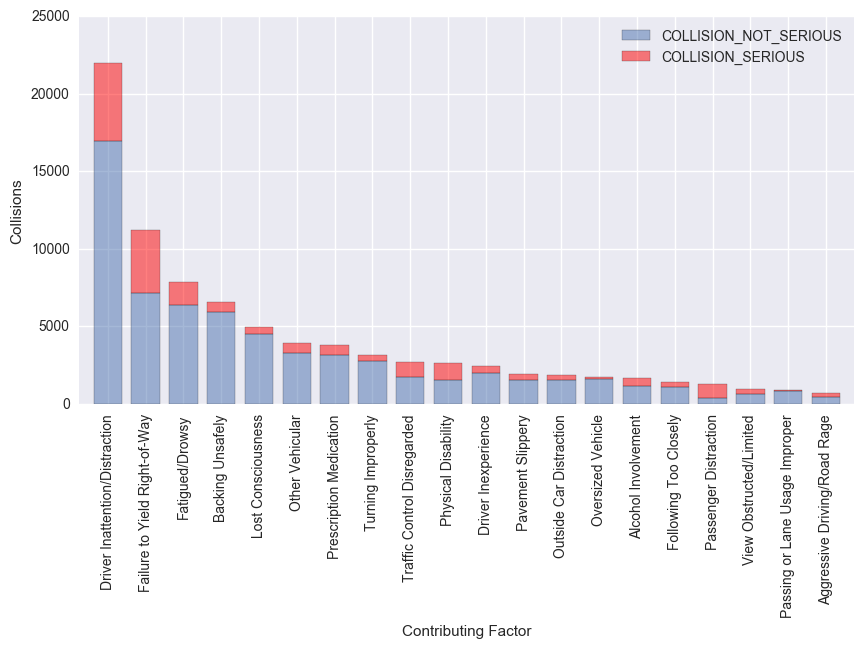

In [127]:
# Create the general blog and the "subplots" i.e. the bars
f, ax1 = plt.subplots(1, figsize=(10,5))

# Set the bar width
bar_width = 0.75

# positions of the left bar-boundaries
bar_l = [i+1 for i in range(len(factors_df_top['COLLISION']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the pre_score data
        factors_df_top['COLLISION_NOT_SERIOUS'], 
        # set the width
        width=bar_width,
        # with the label pre score
        label='COLLISION_NOT_SERIOUS', 
        # with alpha 0.5
        alpha=0.5, 
        # with color
       # color='#F4561D'
       )

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the mid_score data
        factors_df_top['COLLISION_SERIOUS'], 
        # set the width
        width=bar_width,
        # with pre_score on the bottom
        bottom=factors_df_top['COLLISION_NOT_SERIOUS'], 
        # with the label mid score
        label='COLLISION_SERIOUS', 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        #color='#F1911E'
       color = 'red')

# set the x ticks with names
plt.xticks(tick_pos, factors_df_top['CONTRIBUTING FACTOR VEHICLE 1'])
plt.xticks(rotation=90)

# Set the label and legends
ax1.set_ylabel("Collisions")
ax1.set_xlabel("Contributing Factor")
plt.legend(loc='upper right')

# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

### It's easy to see here that just a couple contributing factors account for the majority of total collisions and serious collisions.

### Now I'll take a look at collision location data. Long/lat data might be too granular to be actionable, but should give us a good high level visualization of collisions by type.

In [128]:
long_lat = brooklyn[brooklyn['LATITUDE'] != 0]

In [129]:
long_lat.head()

,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,DATE_TIME,DATE,INTERSECTION,SUM_SERIOUS_COL,COLLISION_SERIOUS,COLLISION,COLLISION_NOT_SERIOUS,DAY_OF_WEEK,DOW,HOUR
0,BROOKLYN,11236.0,40.645032,-73.919978,"(40.6450318, -73.9199775)",RALPH AVENUE,CLARENDON ROAD,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3568080,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,11/17/2016 16:11,2016-11-17 16:11:00,RALPH AVENUE AT CLARENDON ROAD,0,0,1,1,Thursday,3,16
11,BROOKLYN,11220.0,40.632464,-74.009119,"(40.6324635, -74.0091187)",63 STREET,9 AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3562013,SPORT UTILITY / STATION WAGON,VAN,NaN,NaN,NaN,11/15/2016 8:11,2016-11-15 08:11:00,63 STREET AT 9 AVENUE,0,0,1,1,Tuesday,1,8
15,BROOKLYN,11212.0,40.660739,-73.910378,"(40.6607386, -73.9103783)",BRISTOL STREET,RIVERDALE AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3432357,PASSENGER VEHICLE,BICYCLE,NaN,NaN,NaN,04/27/2016 16:00,2016-04-27 16:00:00,BRISTOL STREET AT RIVERDALE AVENUE,0,0,1,1,Wednesday,2,16
22,BROOKLYN,11212.0,40.667096,-73.922752,"(40.6670963, -73.9227518)",RALPH AVENUE,EAST NEW YORK AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3432353,MOTORCYCLE,NaN,NaN,NaN,NaN,04/27/2016 16:25,2016-04-27 16:25:00,RALPH AVENUE AT EAST NEW YORK AVENUE,0,0,1,1,Wednesday,2,16
24,BROOKLYN,11221.0,40.695134,-73.930696,"(40.6951337, -73.9306963)",NaN,NaN,14 LAWTON STREET,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3435122,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,04/27/2016 16:40,2016-04-27 16:40:00,NaN,0,0,1,1,Wednesday,2,16


In [130]:
long_lat_serious = long_lat[long_lat['COLLISION_SERIOUS']==1]
long_lat_not_serious = long_lat[long_lat['COLLISION_SERIOUS']==0]

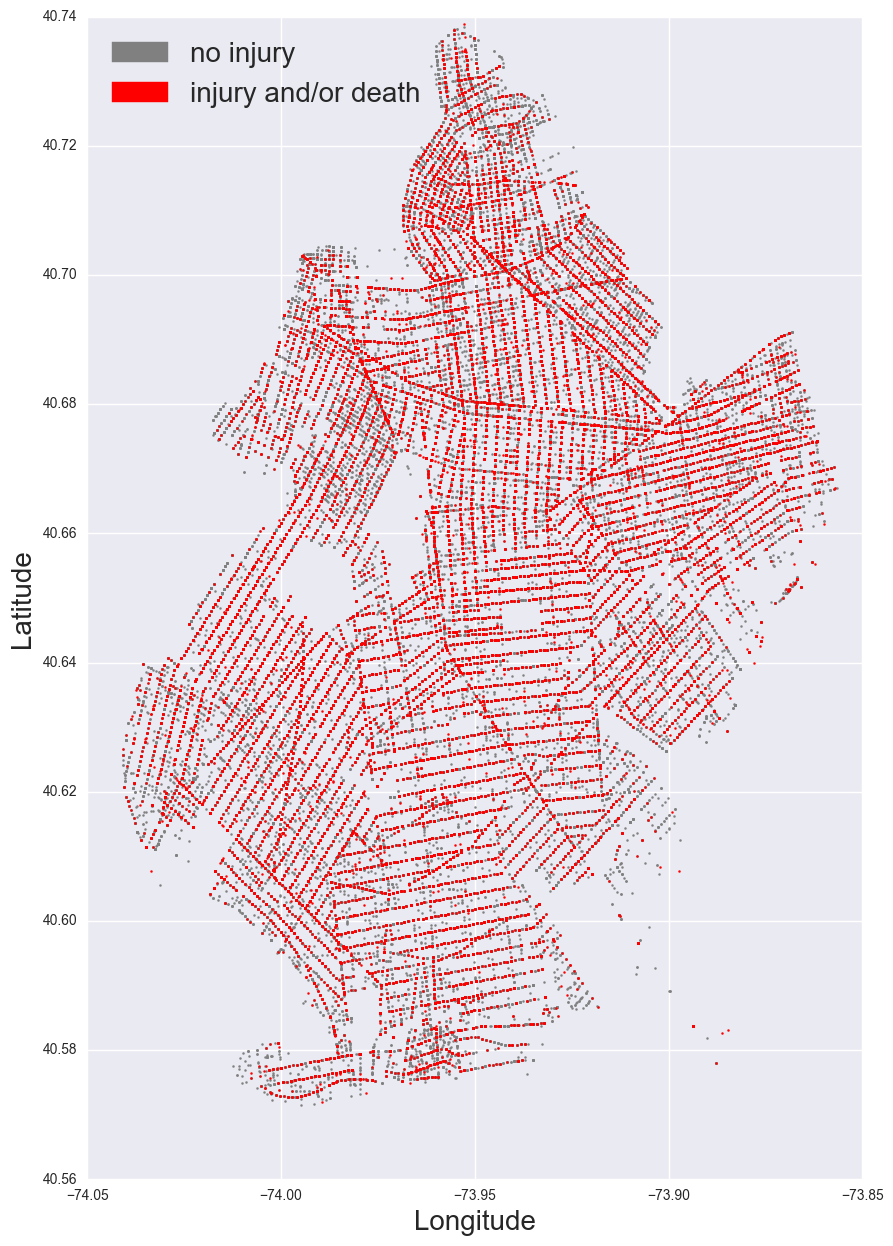

In [131]:
#adjust settings
plt.figure(figsize=(10,15))

#create scatterplots
plt.scatter(long_lat_not_serious.LONGITUDE, long_lat_not_serious.LATITUDE, alpha=1, s=2, color='gray')
plt.scatter(long_lat_serious.LONGITUDE, long_lat_serious.LATITUDE, alpha=1, s=2, color='red')

#create legend
gray_patch = mpatches.Patch( label='collisions - no injury', alpha=1, color='gray')
red_patch = mpatches.Patch(color='red', label='serious', alpha=1)
plt.legend([gray_patch,red_patch],('no injury', 'injury and/or death'),
           loc='upper left', prop={'size':20})

#adjust more settings
# plt.title('Collisions by Seriousness', size=20)
plt.xlim((-74.05,-73.85))
plt.ylim((40.56,40.74))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)

plt.show()

### Might be worth revisiting this view later on - it could be valueable to apply colors to the points based on different conditions, for example

### Checking out collisions by street and by intersection

In [134]:
street_serious = brooklyn[brooklyn['COLLISION_SERIOUS'] == 1][['ON STREET NAME','COLLISION']].groupby('ON STREET NAME').sum()
street_total = brooklyn[['ON STREET NAME','COLLISION']].groupby('ON STREET NAME').sum()

In [135]:
street_serious.head()

,COLLISION
ON STREET NAME,
1 AVENUE,6
1 PLACE,2
1 STREET,5
10 AVENUE,69
10 STREET,3


In [136]:
street_serious.shape

(1230, 1)

In [137]:
street_total.shape

(1763, 1)

In [138]:
street_serious = street_serious.sort_values('COLLISION', ascending = False)
street_total = street_total.sort_values('COLLISION',ascending = False)

In [139]:
print 'PCT serious collisions on 50 highest volume streets: ',float(street_serious['COLLISION'][:50].sum())/street_serious['COLLISION'].sum()
print 'PCT not serious collisions on 50 highest volume streets: ',float(street_total['COLLISION'][:50].sum())/street_total['COLLISION'].sum()

PCT serious collisions on 50 highest volume streets:  0.450925129088
PCT not serious collisions on 50 highest volume streets:  0.401174904503


In [141]:
#top 50 streets by collisions, total and serious
street_serious_50 = street_serious[:50]
street_serious_50 = street_serious_50.sort_values('COLLISION',ascending = True)
street_total_50 = street_total[:50]
street_total_50 = street_total_50.sort_values('COLLISION',ascending = True)

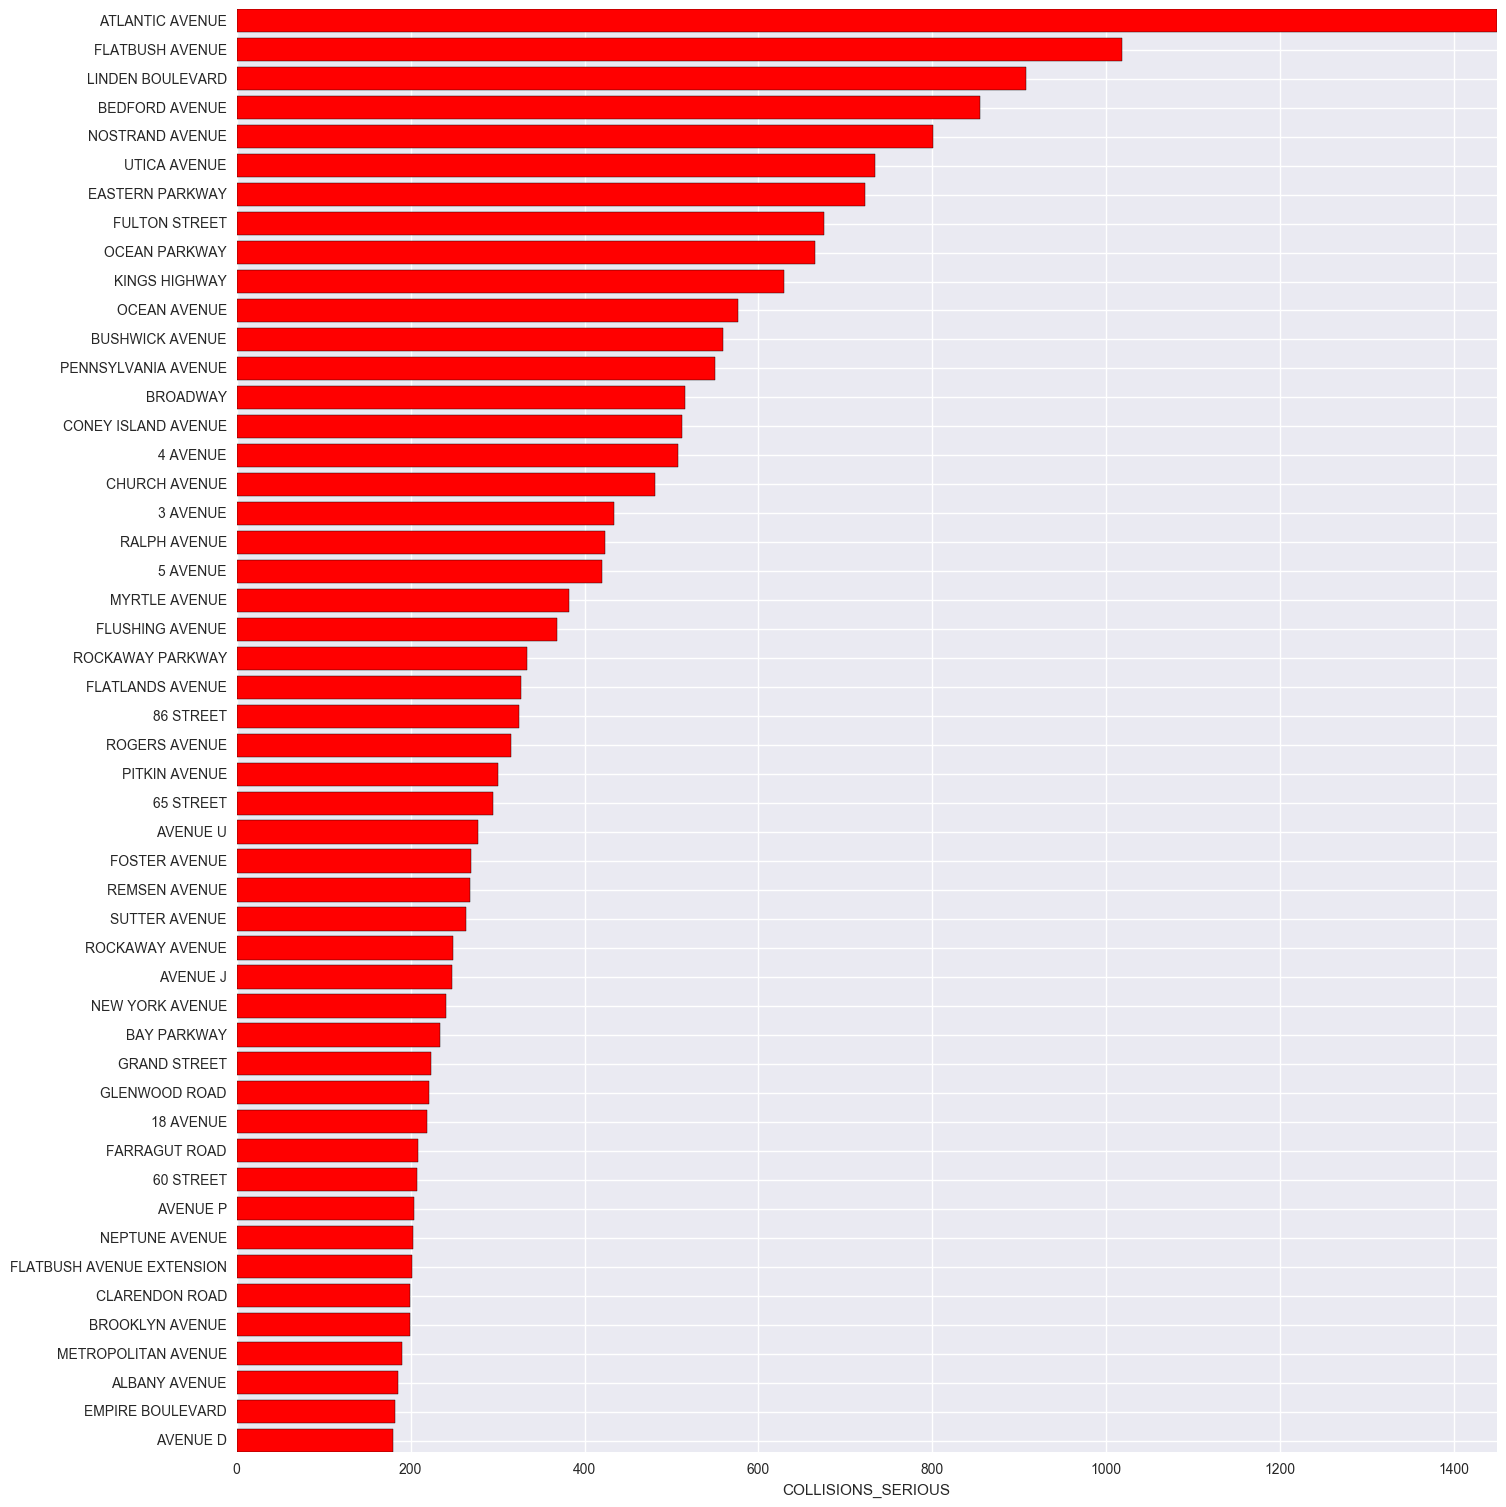

In [142]:
fig, ax = plt.subplots(figsize=(15, 15))

y_pos = np.arange(street_serious_50.count())
cols_s = street_serious_50.values
 
ax.barh(y_pos, cols_s, align = 'center',color = 'red')
plt.xlabel('COLLISIONS_SERIOUS')
plt.yticks(y_pos, street_serious_50.index)
ax.autoscale_view('tight')
fig.tight_layout(pad=.5)

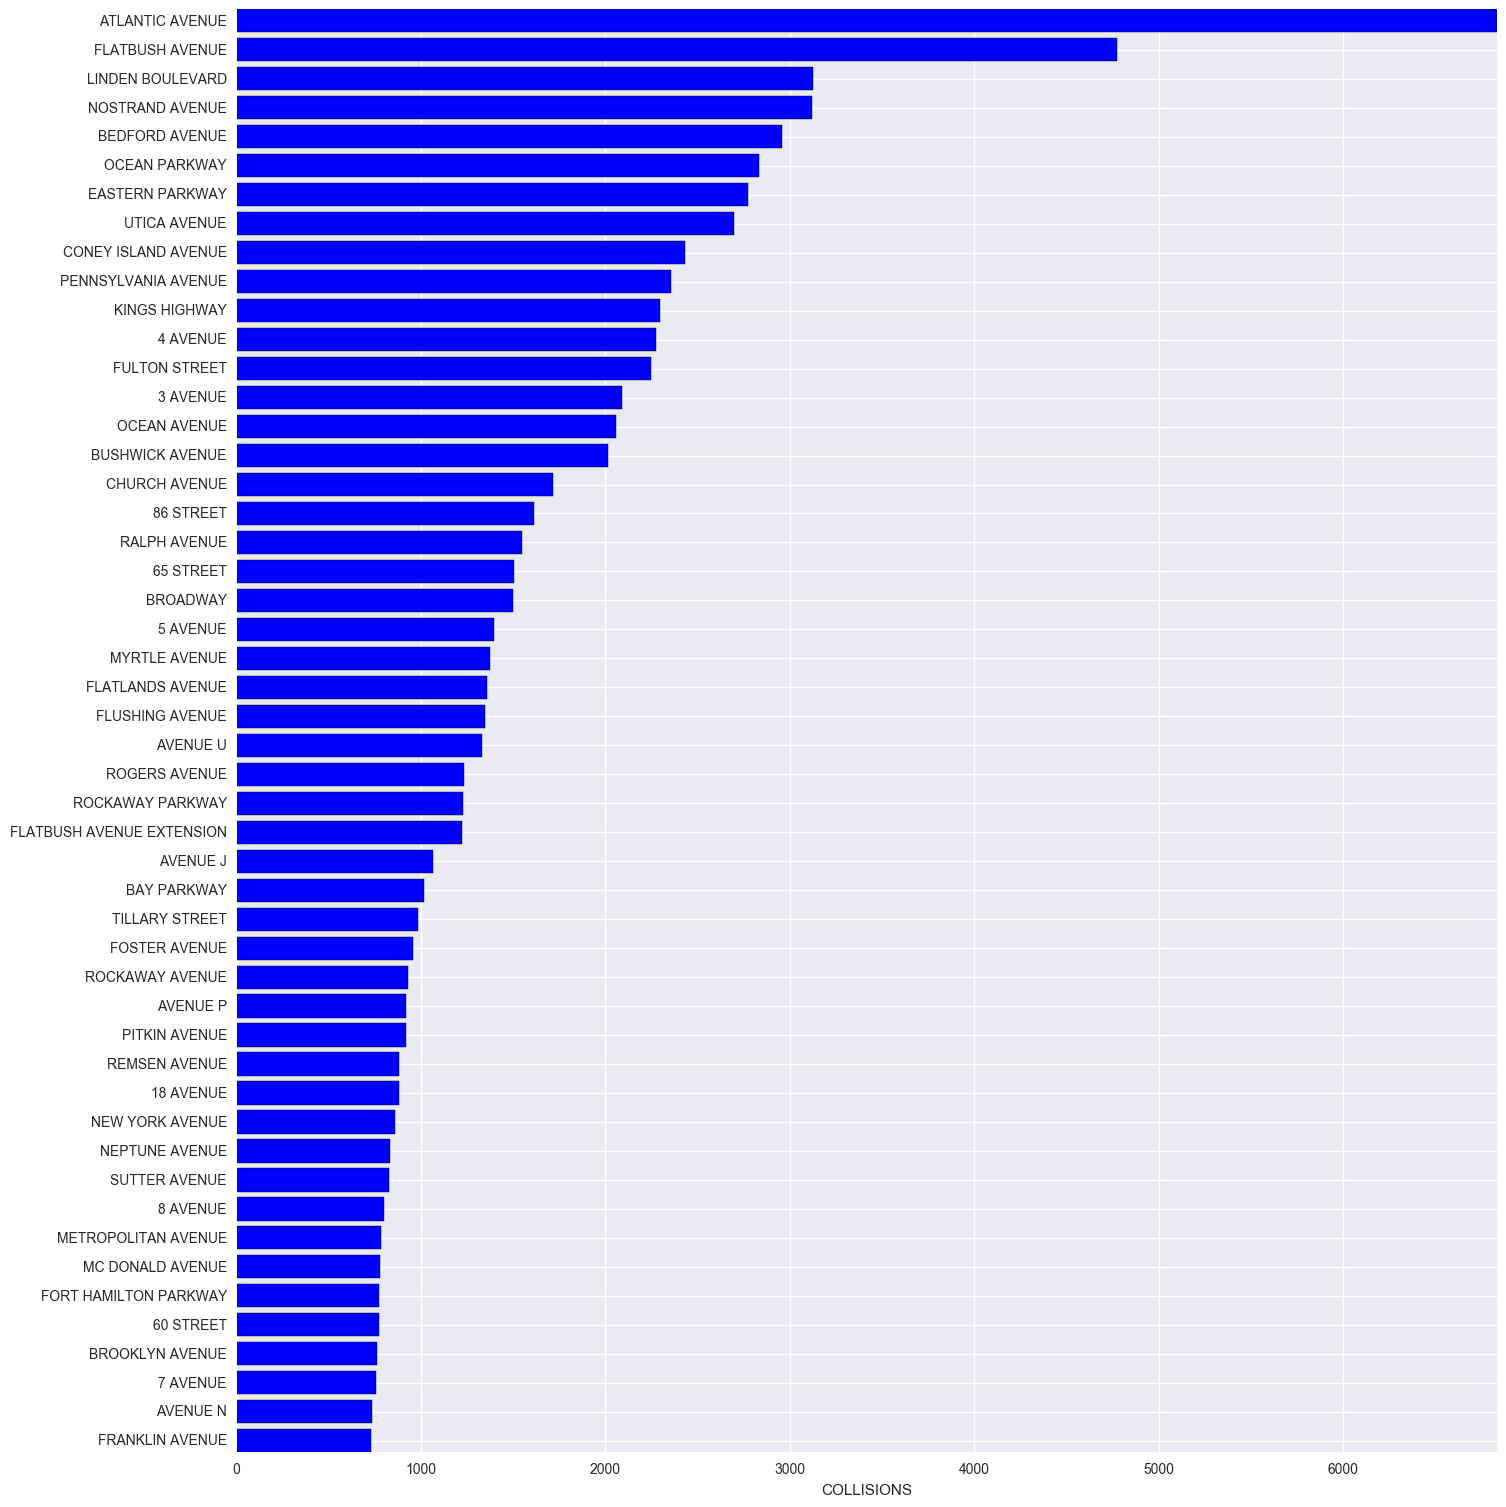

In [143]:
fig, ax = plt.subplots(figsize=(15, 15))

y_pos = np.arange(street_total_50.count())
cols_s = street_total_50.values
 
ax.barh(y_pos, cols_s, align = 'center',color = 'blue')
plt.xlabel('COLLISIONS')
plt.yticks(y_pos, street_total_50.index)
ax.autoscale_view('tight')
fig.tight_layout(pad=.5)

In [144]:
intersection_serious = brooklyn[brooklyn['COLLISION_SERIOUS'] == 1][['INTERSECTION','COLLISION']].groupby('INTERSECTION').sum()
intersection_total = brooklyn[['INTERSECTION','COLLISION']].groupby('INTERSECTION').sum()

In [145]:
intersection_serious.head()

,COLLISION
INTERSECTION,
1 AVENUE AT 44 STREET,1
1 AVENUE AT 53 STREET,2
1 AVENUE AT 55 STREET,1
1 AVENUE AT 56 STREET,1
1 AVENUE AT 58 STREET,1


In [146]:
intersection_serious.shape

(13185, 1)

In [147]:
intersection_total.shape

(20017, 1)

In [148]:
intersection_serious = intersection_serious.sort_values('COLLISION', ascending = False)
intersection_total = intersection_total.sort_values('COLLISION',ascending = False)

In [149]:
print 'PCT serious collisions on 50 highest volume intersections: ',float(intersection_serious['COLLISION'][:50].sum())/intersection_serious['COLLISION'].sum()
print 'PCT not serious collisions on 50 highest volume intersections: ',float(intersection_total['COLLISION'][:50].sum())/intersection_total['COLLISION'].sum()

PCT serious collisions on 50 highest volume intersections:  0.0453528399312
PCT not serious collisions on 50 highest volume intersections:  0.04425184242


In [150]:
#top 50 intersections by collisions, total and serious
intersection_serious_50 = intersection_serious[:50]
intersection_serious_50 = intersection_serious_50.sort_values('COLLISION',ascending = True)
intersection_total_50 = intersection_total[:50]
intersection_total_50 = intersection_total_50.sort_values('COLLISION',ascending = True)

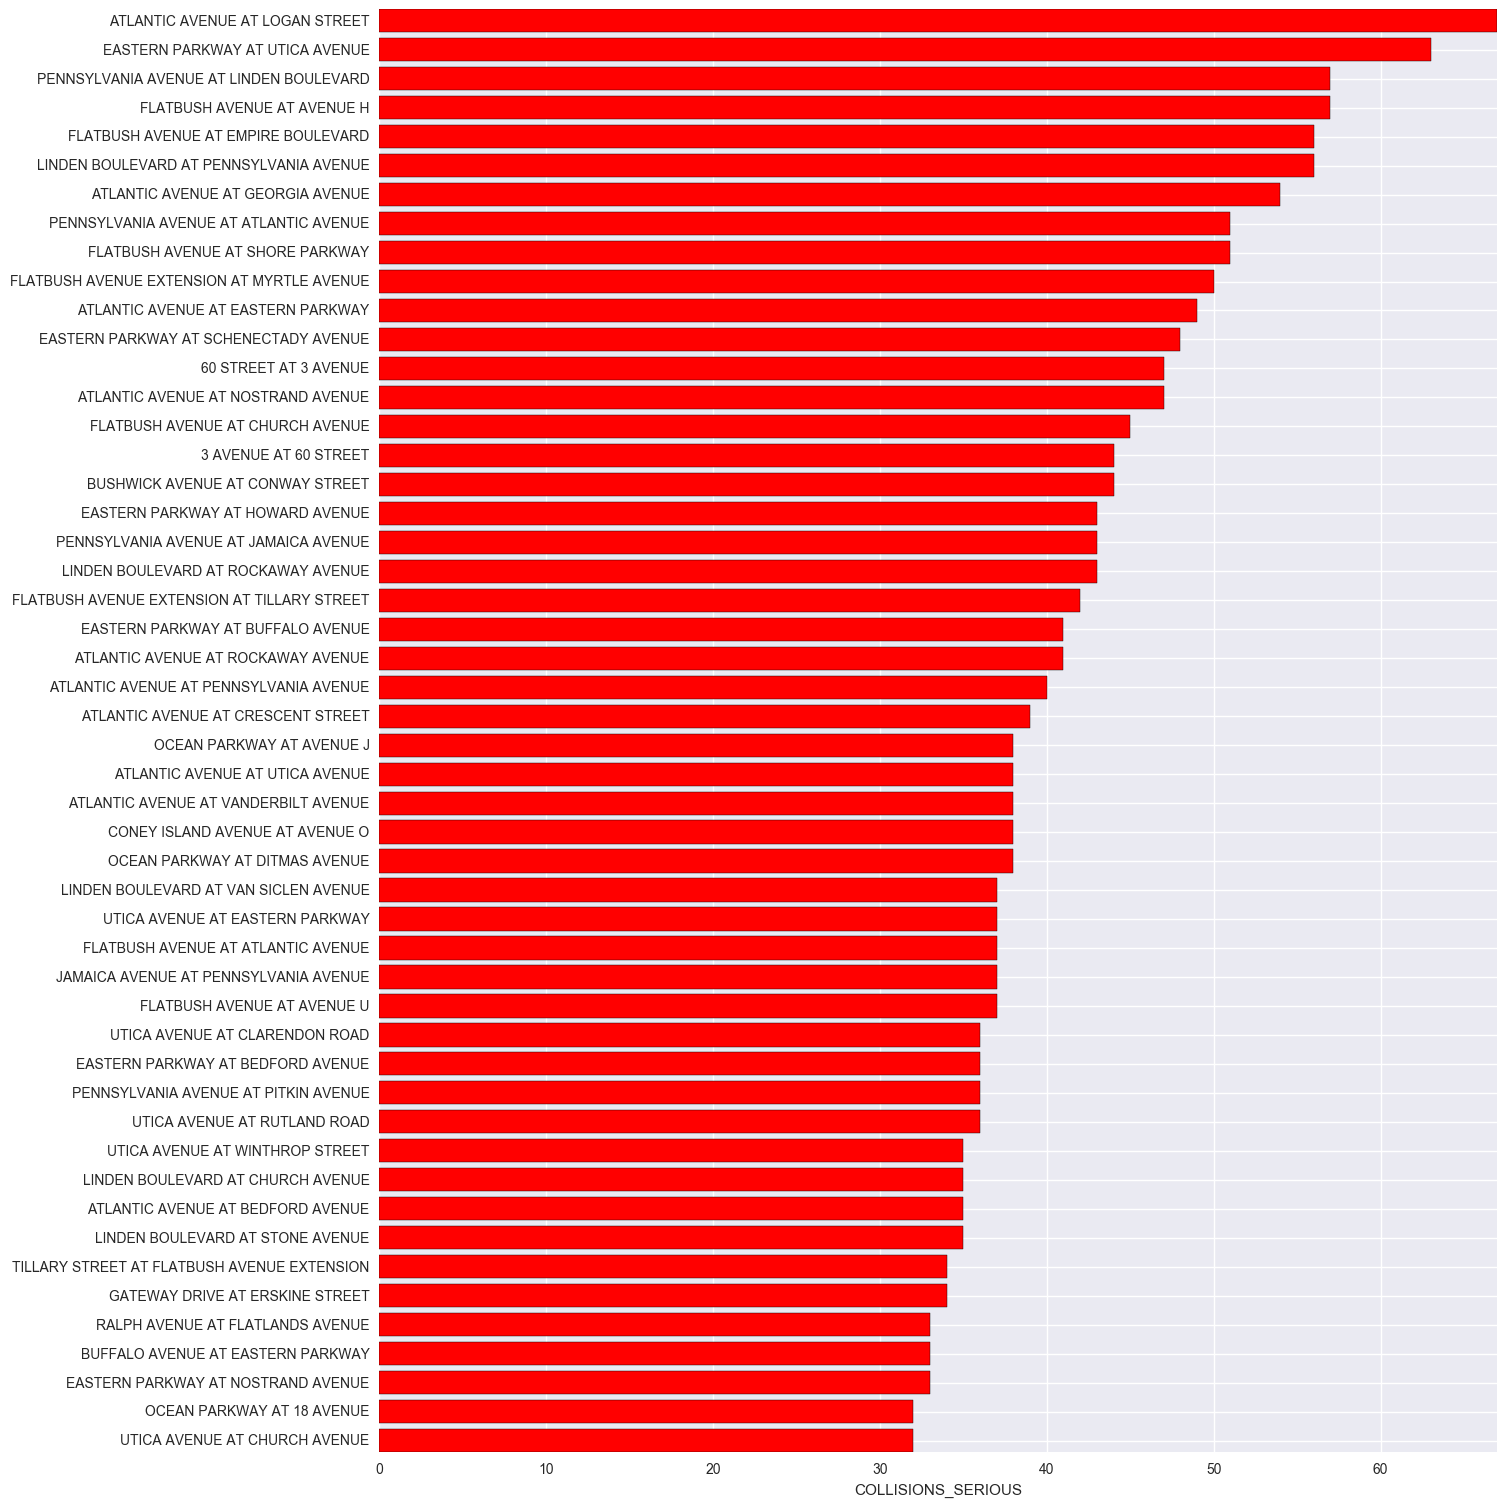

In [151]:
fig, ax = plt.subplots(figsize=(15, 15))

y_pos = np.arange(intersection_serious_50.count())
cols_s = intersection_serious_50.values
 
ax.barh(y_pos, cols_s, align = 'center',color = 'red')
plt.xlabel('COLLISIONS_SERIOUS')
plt.yticks(y_pos, intersection_serious_50.index)
ax.autoscale_view('tight')
fig.tight_layout(pad=.5)

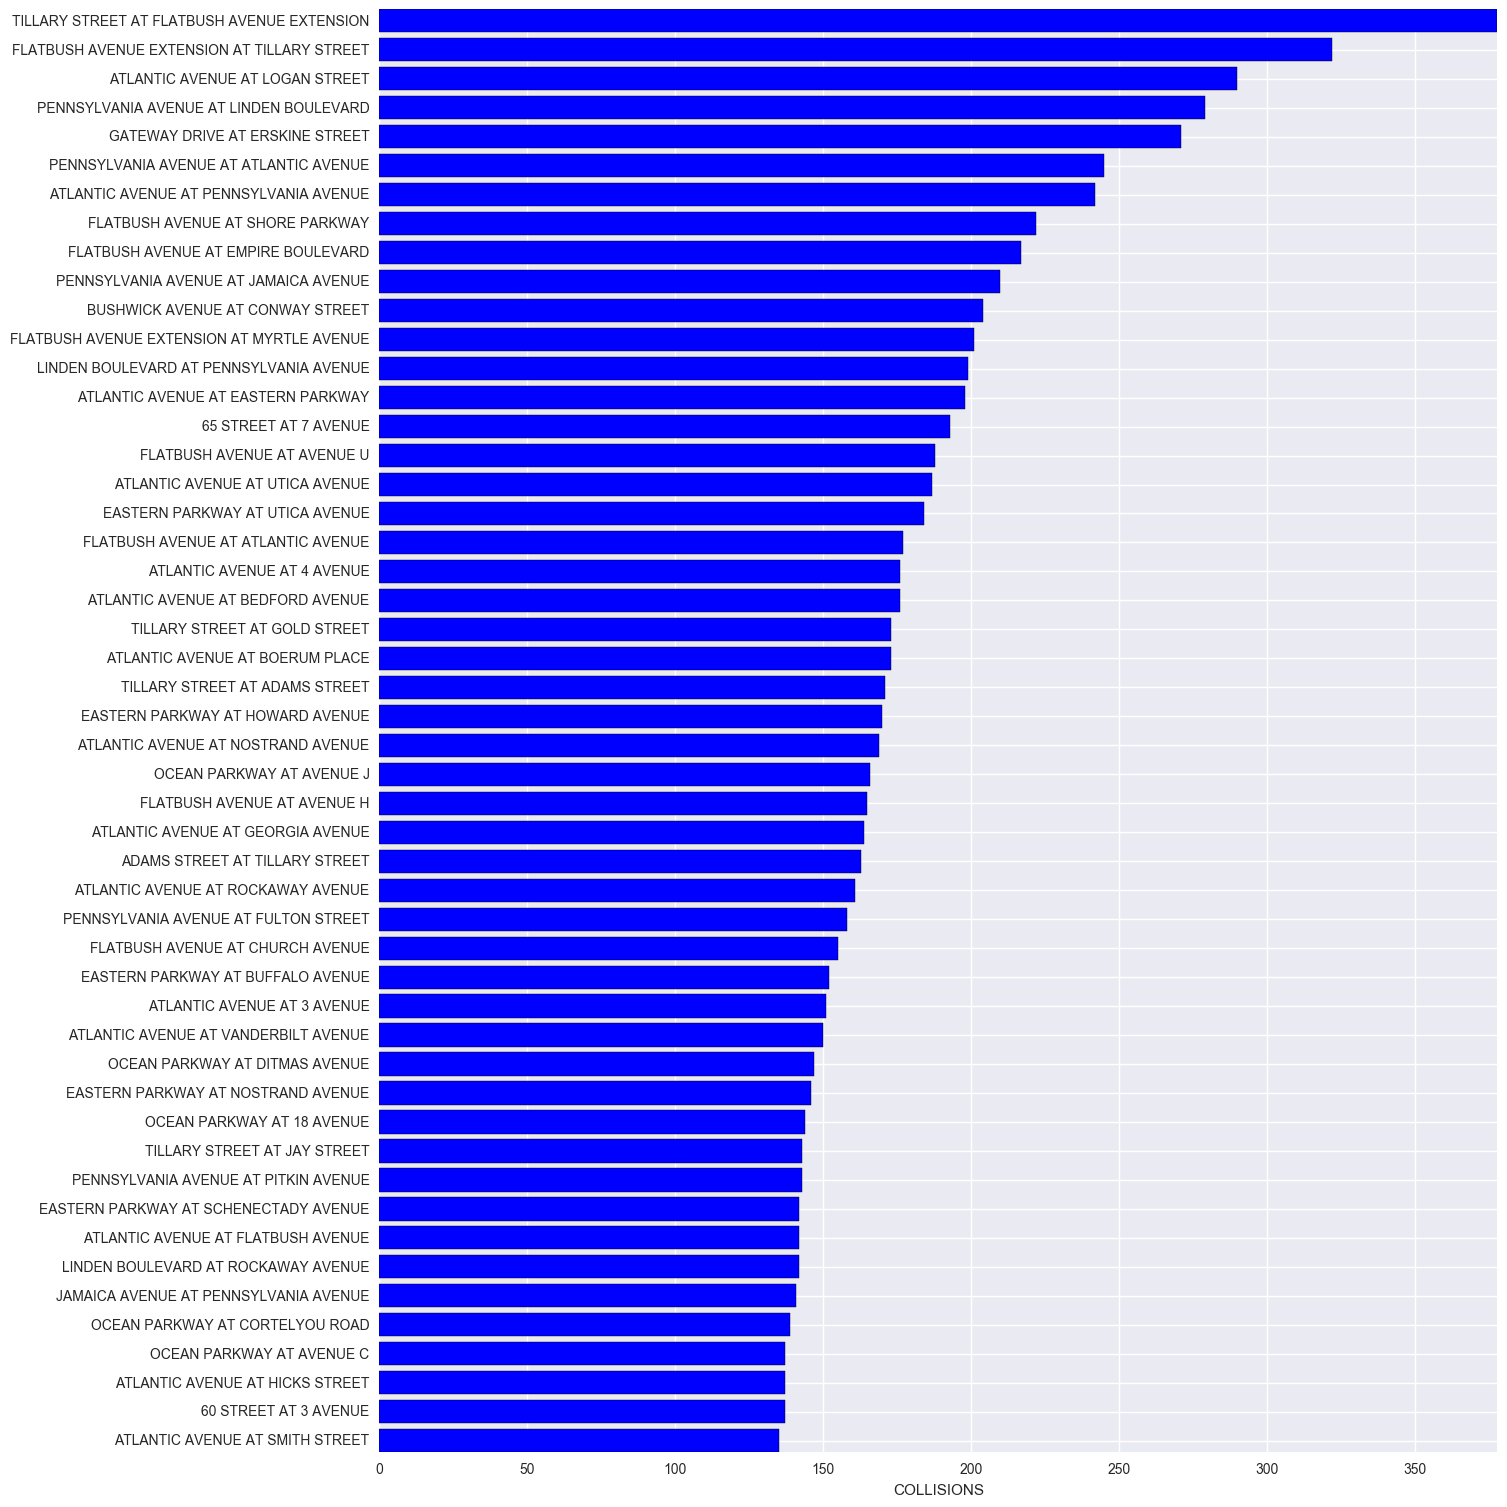

In [152]:
fig, ax = plt.subplots(figsize=(15, 15))

y_pos = np.arange(intersection_total_50.count())
cols_s = intersection_total_50.values
 
ax.barh(y_pos, cols_s, align = 'center',color = 'blue')
plt.xlabel('COLLISIONS')
plt.yticks(y_pos, intersection_total_50.index)
ax.autoscale_view('tight')
fig.tight_layout(pad=.5)

### Looking into collisions across time

In [154]:
#adding a column of month/year datatime objects 
brooklyn['year'], brooklyn['month'] = brooklyn['DATE'].dt.year, brooklyn['DATE'].dt.month
brooklyn['y_m'] = brooklyn.year.map(str) + "/" + brooklyn.month.map(str)
brooklyn['year_month'] = pd.to_datetime(brooklyn['y_m'], format = '%Y/%m')

/Users/mdcorey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mdcorey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/mdcorey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [155]:
brooklyn.head()

,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,DATE_TIME,DATE,INTERSECTION,SUM_SERIOUS_COL,COLLISION_SERIOUS,COLLISION,COLLISION_NOT_SERIOUS,DAY_OF_WEEK,DOW,HOUR,year,month,y_m,year_month
0,BROOKLYN,11236.0,40.645032,-73.919978,"(40.6450318, -73.9199775)",RALPH AVENUE,CLARENDON ROAD,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3568080,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,11/17/2016 16:11,2016-11-17 16:11:00,RALPH AVENUE AT CLARENDON ROAD,0,0,1,1,Thursday,3,16,2016,11,2016/11,2016-11-01
11,BROOKLYN,11220.0,40.632464,-74.009119,"(40.6324635, -74.0091187)",63 STREET,9 AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3562013,SPORT UTILITY / STATION WAGON,VAN,NaN,NaN,NaN,11/15/2016 8:11,2016-11-15 08:11:00,63 STREET AT 9 AVENUE,0,0,1,1,Tuesday,1,8,2016,11,2016/11,2016-11-01
15,BROOKLYN,11212.0,40.660739,-73.910378,"(40.6607386, -73.9103783)",BRISTOL STREET,RIVERDALE AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3432357,PASSENGER VEHICLE,BICYCLE,NaN,NaN,NaN,04/27/2016 16:00,2016-04-27 16:00:00,BRISTOL STREET AT RIVERDALE AVENUE,0,0,1,1,Wednesday,2,16,2016,4,2016/4,2016-04-01
22,BROOKLYN,11212.0,40.667096,-73.922752,"(40.6670963, -73.9227518)",RALPH AVENUE,EAST NEW YORK AVENUE,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3432353,MOTORCYCLE,NaN,NaN,NaN,NaN,04/27/2016 16:25,2016-04-27 16:25:00,RALPH AVENUE AT EAST NEW YORK AVENUE,0,0,1,1,Wednesday,2,16,2016,4,2016/4,2016-04-01
24,BROOKLYN,11221.0,40.695134,-73.930696,"(40.6951337, -73.9306963)",NaN,NaN,14 LAWTON STREET,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,3435122,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,04/27/2016 16:40,2016-04-27 16:40:00,NaN,0,0,1,1,Wednesday,2,16,2016,4,2016/4,2016-04-01


In [156]:
over_time = brooklyn[['year_month','COLLISION', 'COLLISION_SERIOUS', 'COLLISION_NOT_SERIOUS']].groupby('year_month').sum()

In [157]:
over_time.head()

,COLLISION,COLLISION_SERIOUS,COLLISION_NOT_SERIOUS
year_month,,,
2012-07-01,3884,974,2910
2012-08-01,3915,966,2949
2012-09-01,3786,955,2831
2012-10-01,3881,936,2945
2012-11-01,3752,801,2951


In [159]:
#creating Series objects for the plot
over_time_total = over_time['COLLISION']
over_time_serious = over_time['COLLISION_SERIOUS']
over_time_not_serious = over_time['COLLISION_NOT_SERIOUS']
over_time_dates = over_time.index

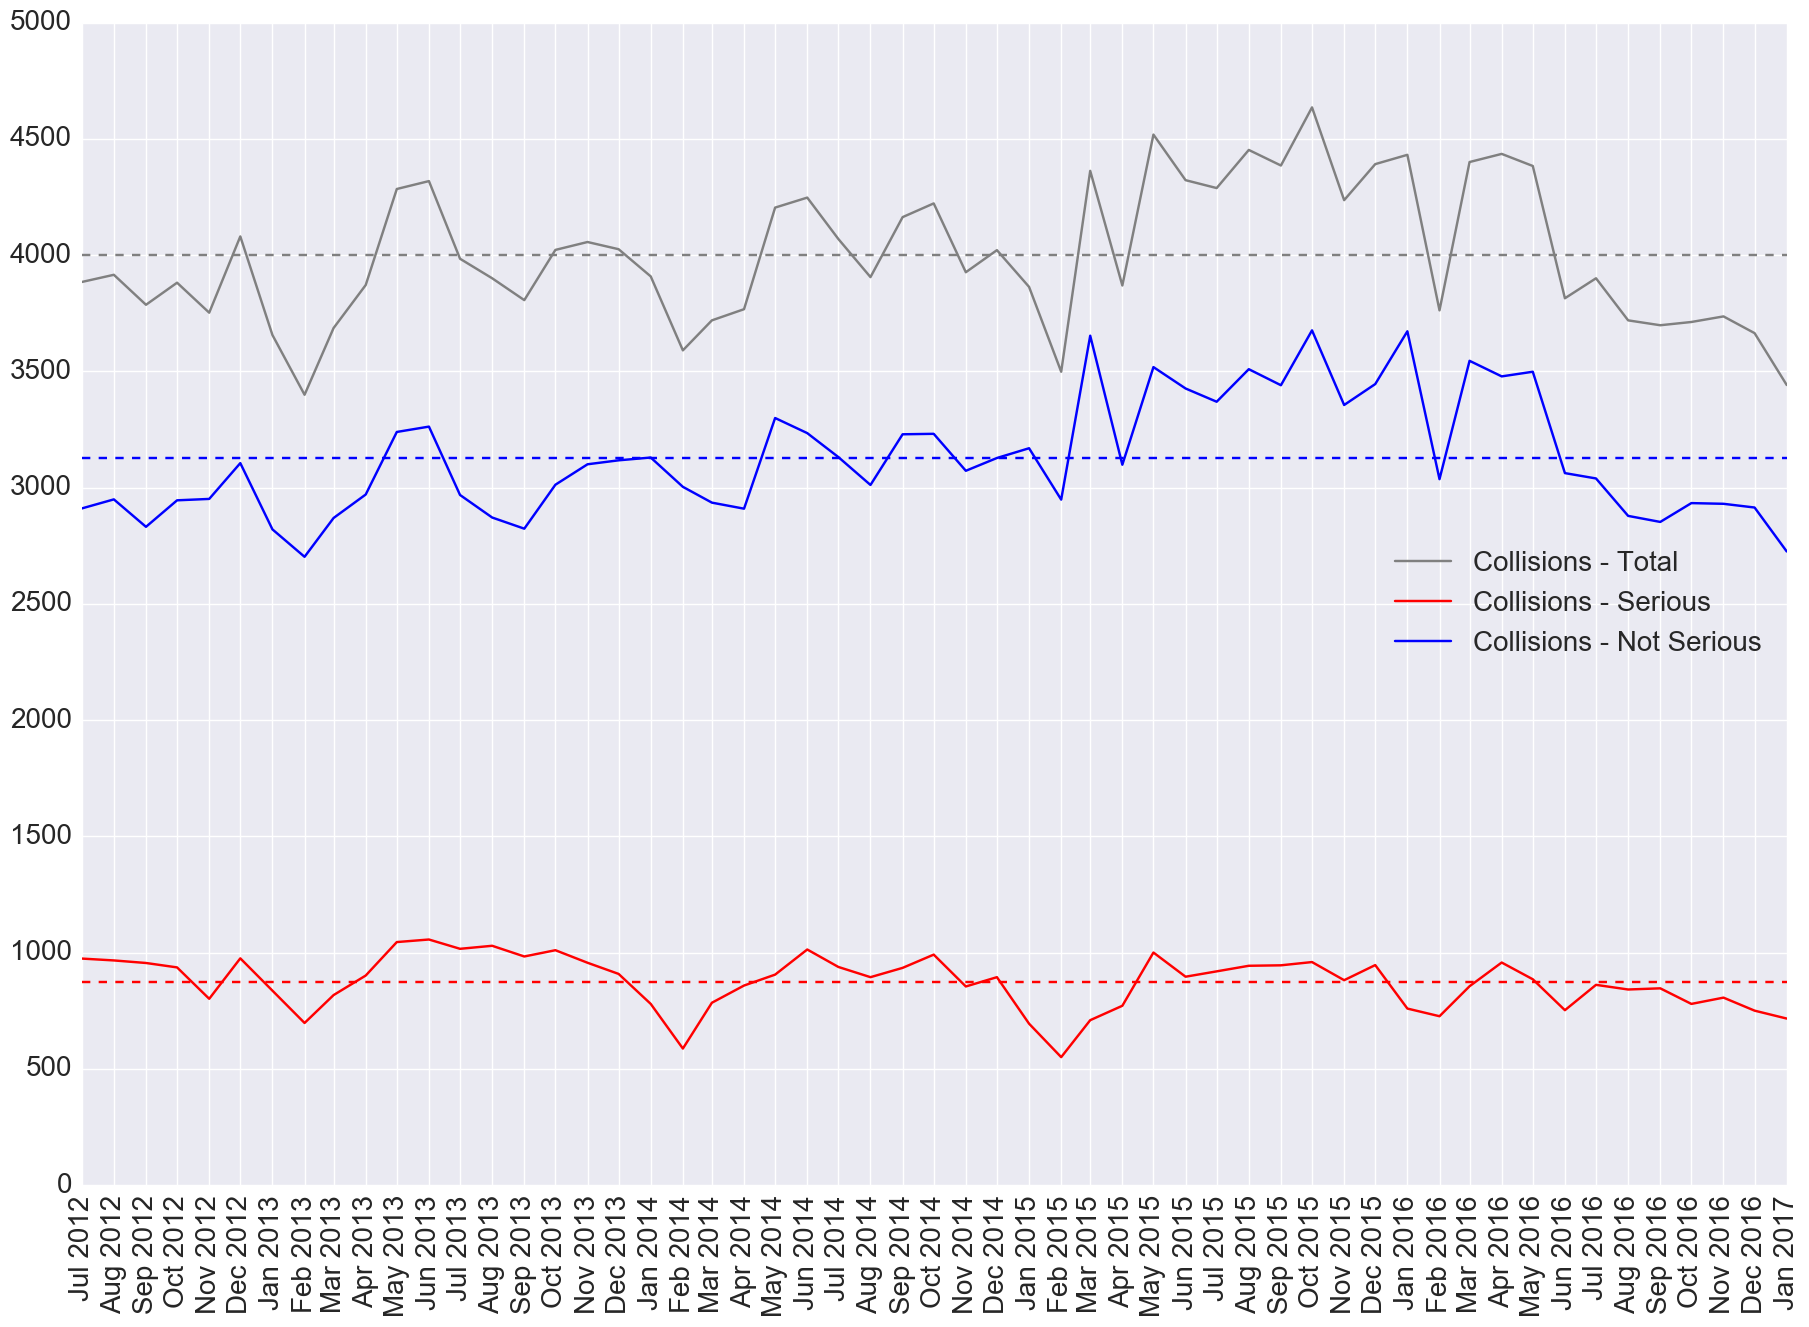

In [163]:
#creating figure, dropping the last month from each serious since its not complete
fig, ax = plt.subplots(figsize=(22, 15))
plt.gca().set_color_cycle(['gray', 'red', 'blue'])
ax.plot(over_time_dates[:-1], over_time_total[:-1])
ax.plot(over_time_dates[:-1], over_time_serious[:-1])
ax.plot(over_time_dates[:-1], over_time_not_serious[:-1])

ax.axhline(y=over_time_total[:-1].mean(), color = 'gray', ls = '--')
ax.axhline(y=over_time_serious[:-1].mean(), color = 'red', ls = '--')
ax.axhline(y=over_time_not_serious[:-1].mean(), color = 'blue', ls = '--')

plt.xticks(rotation=90)
ax.locator_params(nticks=56, axis='x')
ax.locator_params(nticks=10, axis='y')
ax.set_xticks(over_time_dates[:-1])
ax.set_yticks([0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000])
plt.tick_params(axis='both', which='major', labelsize=20)

plt.legend(['Collisions - Total', 'Collisions - Serious', 'Collisions - Not Serious'], loc='center right', fontsize=20)

### there seems to be some seasonality with serious collisions where they drop in the winter and then rise and flatten from spring through fall.  

### there is also a big spike in non serious collisions beginning in early 2015 and lasting through mid 2016 where there is a big drop off

### we can try to understand the seasonality in serious collisions by incorporating some additional data on motorist/cyclist/pedestrian injuries and deaths. 

In [164]:
#new dataframe with granular injury data
over_time_serious_granular = brooklyn[['year_month','COLLISION','NUMBER OF PEDESTRIANS INJURED', \
                                                'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
                                                'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
                                                'NUMBER OF MOTORIST KILLED']]

In [165]:
#creating booleans for each
over_time_serious_granular['bike_serious'] = np.where((over_time_serious_granular['NUMBER OF CYCLIST KILLED'] + over_time_serious_granular['NUMBER OF CYCLIST INJURED'] >0) , 1, 0)
over_time_serious_granular['ped_serious'] = np.where((over_time_serious_granular['NUMBER OF PEDESTRIANS KILLED'] + over_time_serious_granular['NUMBER OF PEDESTRIANS INJURED'] >0) , 1, 0)
over_time_serious_granular['motorist_serious'] = np.where((over_time_serious_granular['NUMBER OF MOTORIST KILLED'] + over_time_serious_granular['NUMBER OF MOTORIST INJURED'] >0) , 1, 0)

/Users/mdcorey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/mdcorey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mdcorey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [166]:
over_time_serious_granular.head()

,year_month,COLLISION,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,bike_serious,ped_serious,motorist_serious
0,2016-11-01,1,0,0,0,0,0,0,0,0,0
11,2016-11-01,1,0,0,0,0,0,0,0,0,0
15,2016-04-01,1,0,0,0,0,0,0,0,0,0
22,2016-04-01,1,0,0,0,0,0,0,0,0,0
24,2016-04-01,1,0,0,0,0,0,0,0,0,0


In [172]:
print 'Serious collisions involving cyclists: ',over_time_serious_granular[over_time_serious_granular['bike_serious'] \
                                                                           != 0]['COLLISION'].count()
print 'Serious collisions involving motorists: ',over_time_serious_granular[over_time_serious_granular['motorist_serious'] \
                                                                           != 0]['COLLISION'].count()
print 'Serious collisions involving pedestrians: ',over_time_serious_granular[over_time_serious_granular['ped_serious'] \
                                                                           != 0]['COLLISION'].count()

 Serious collisions involving cyclists:  6830
Serious collisions involving motorists:  27339
Serious collisions involving pedestrians:  14641


In [176]:
total_serious_collisions= brooklyn[brooklyn['COLLISION_SERIOUS'] != 0]['COLLISION_SERIOUS'].count()

In [178]:
print 'PCT of serious collisions - hurt/killed cyclists :', (over_time_serious_granular[over_time_serious_granular['bike_serious'] \
                                                                           != 0]['COLLISION'].count())/float(total_serious_collisions)
print 'PCT of serious collisions - hurt/killed pedestrians :', (over_time_serious_granular[over_time_serious_granular['ped_serious'] \
                                                                           != 0]['COLLISION'].count())/float(total_serious_collisions)
print 'PCT of serious collisions - hurt/killed motorists :', (over_time_serious_granular[over_time_serious_granular['motorist_serious'] \
                                                                           != 0]['COLLISION'].count())/float(total_serious_collisions)

PCT of serious collisions - hurt/killed cyclists : 0.140720290094
PCT of serious collisions - hurt/killed pedestrians : 0.301652381737
PCT of serious collisions - hurt/killed motorists : 0.563272622383


### 44% of all serious collisions involve at least one pedestrian or cyclist
### adding this data to a visualization of serious collisions over time...

In [182]:
serious_granular_by_ym = over_time_serious_granular[['year_month','bike_serious',\
                                                     'ped_serious','motorist_serious']].groupby('year_month').sum()

In [183]:
serious_granular_by_ym.head()

,bike_serious,ped_serious,motorist_serious
year_month,,,
2012-07-01,175,256,548
2012-08-01,207,257,512
2012-09-01,162,270,536
2012-10-01,138,288,516
2012-11-01,107,316,380


In [184]:
serious_granular_bike = serious_granular_by_ym['bike_serious']
serious_granular_ped = serious_granular_by_ym['ped_serious']
serious_granular_motorist = serious_granular_by_ym['motorist_serious']

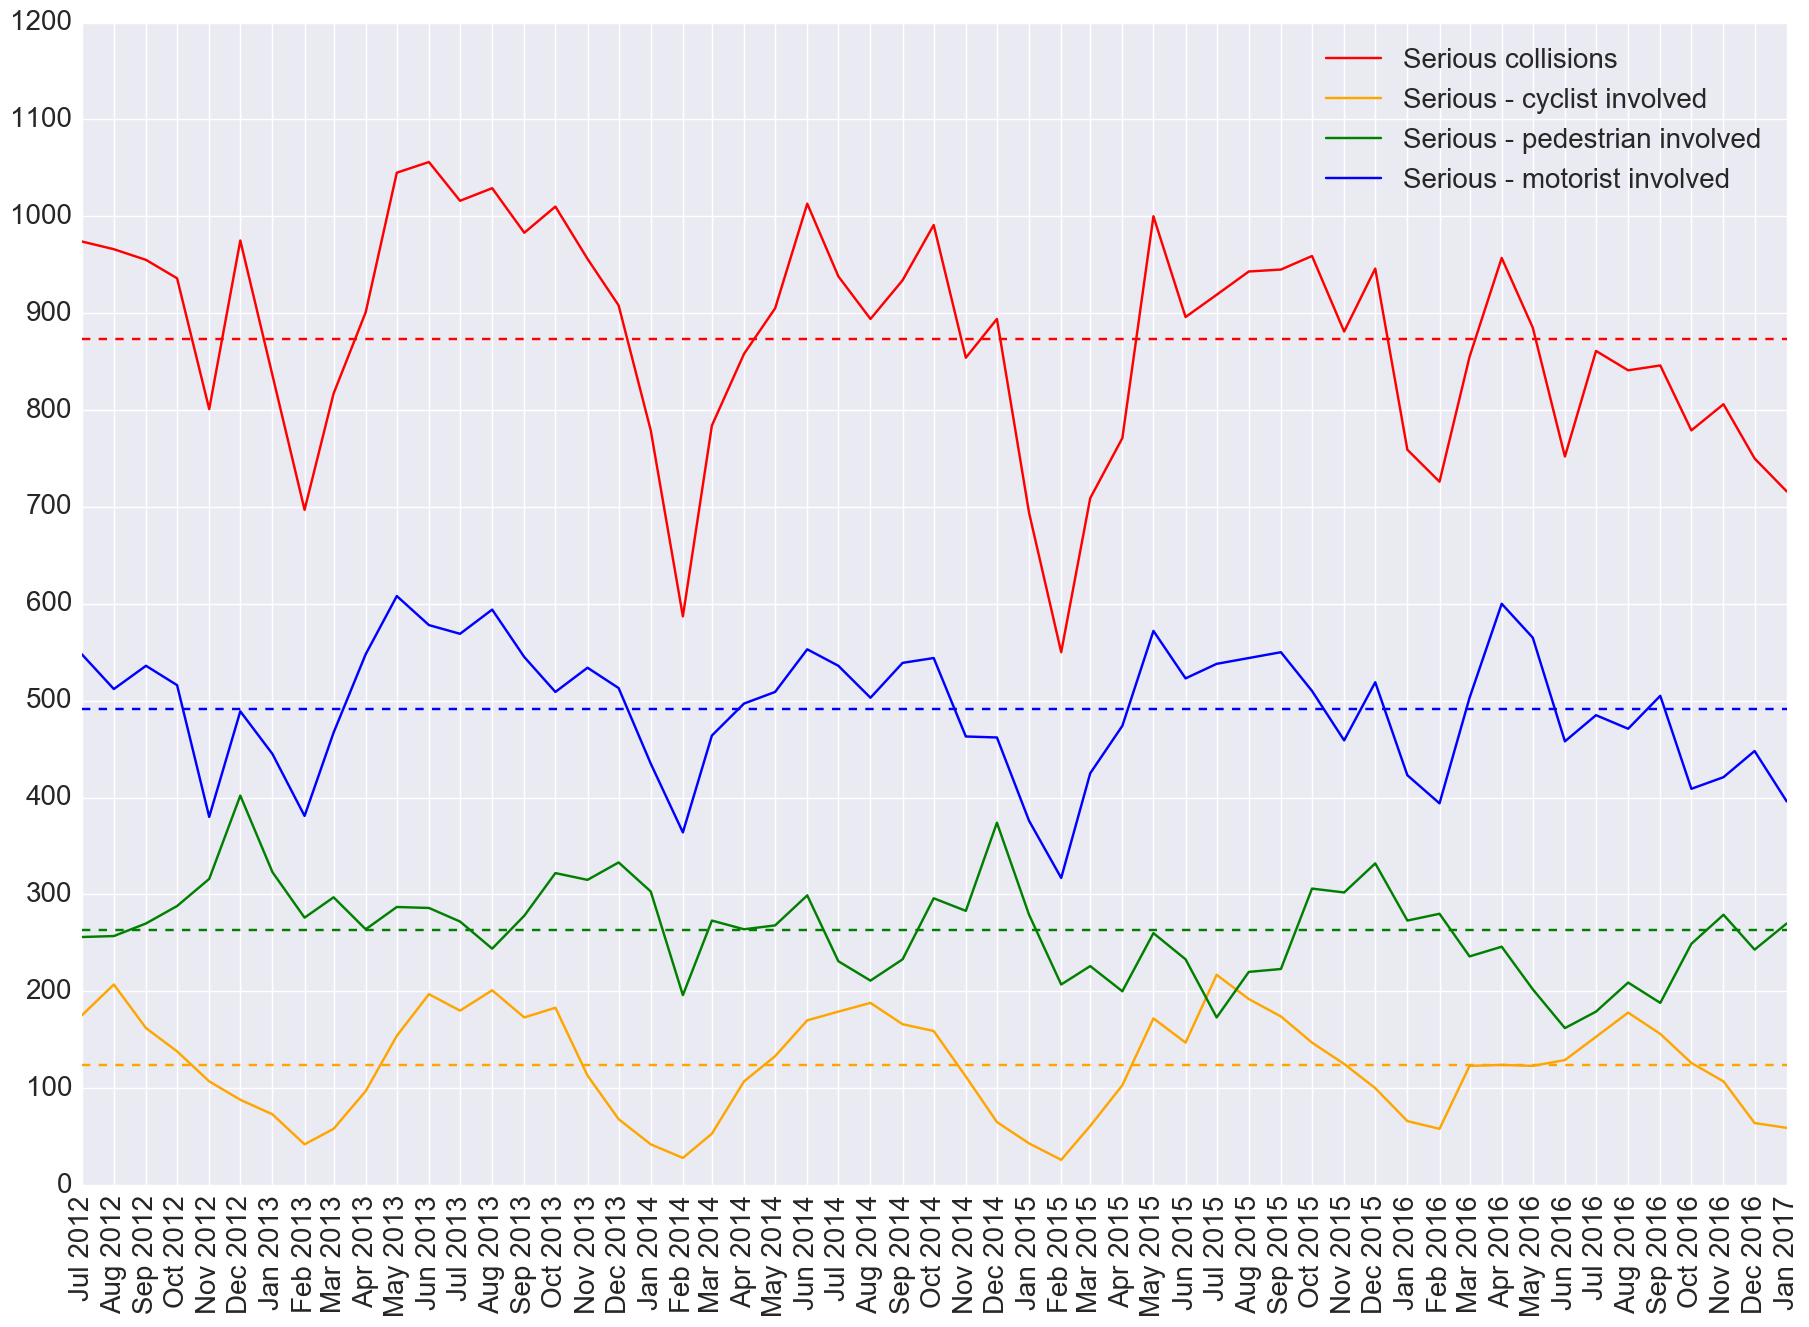

In [188]:
#creating figure, dropping the last month from each serious since its not complete
fig, ax = plt.subplots(figsize=(22, 15))
plt.gca().set_color_cycle(['red', 'orange', 'green','blue'])
# ax.plot(over_time_dates[:-1], over_time_total[:-1])
ax.plot(over_time_dates[:-1], over_time_serious[:-1])
ax.plot(over_time_dates[:-1], serious_granular_bike[:-1])
ax.plot(over_time_dates[:-1], serious_granular_ped[:-1])
ax.plot(over_time_dates[:-1], serious_granular_motorist[:-1])

ax.axhline(y=over_time_serious[:-1].mean(), color = 'red', ls = '--')
ax.axhline(y=serious_granular_bike[:-1].mean(), color = 'orange', ls = '--')
ax.axhline(y=serious_granular_ped[:-1].mean(), color = 'green', ls = '--')
ax.axhline(y=serious_granular_motorist[:-1].mean(), color = 'blue', ls = '--')

plt.xticks(rotation=90)
ax.locator_params(nticks=56, axis='x')
ax.locator_params(nticks=10, axis='y')
ax.set_xticks(over_time_dates[:-1])
ax.set_yticks([0,100,200,300,400,500,600,700,800,900,1000,1100,1200])
plt.tick_params(axis='both', which='major', labelsize=20)

plt.legend(['Serious collisions', 'Serious - cyclist involved', 'Serious - pedestrian involved',\
           'Serious - motorist involved'], loc='upper right', fontsize=20)

### serious cyclist collisions are highly seasonal.  Interestingly, serious pedestrian collisions spike in the winter when cyclist deaths plunge.  Could be fewer cyclists on the road and more pedestrians (and/or weather or other external conditions raising pedestrian collisions )

### checking out collisions by vehicle type...

In [232]:
#pulling in other fields I may want to slice the vehicle data by
vehicle_df = brooklyn[['VEHICLE TYPE CODE 1','CONTRIBUTING FACTOR VEHICLE 1', 'DATE', 'year_month', 'year', \
                    'COLLISION','COLLISION_NOT_SERIOUS','COLLISION_SERIOUS']]

In [233]:
#checking out collisions sorted by vehicle type...
vehicle_df[['VEHICLE TYPE CODE 1','COLLISION']].groupby('VEHICLE TYPE CODE 1').sum().\
    sort_values('COLLISION',ascending = False)

,COLLISION
VEHICLE TYPE CODE 1,
PASSENGER VEHICLE,133371
SPORT UTILITY / STATION WAGON,51417
OTHER,6907
VAN,6189
UNKNOWN,5139
BUS,3324
SMALL COM VEH(4 TIRES),3138
PICK-UP TRUCK,2811
LARGE COM VEH(6 OR MORE TIRES),2762


In [234]:
#...and serious collisions by vehicle type
vehicle_df[['VEHICLE TYPE CODE 1','COLLISION_SERIOUS']].groupby('VEHICLE TYPE CODE 1').sum().\
    sort_values('COLLISION_SERIOUS',ascending = False)

,COLLISION_SERIOUS
VEHICLE TYPE CODE 1,
PASSENGER VEHICLE,28632
SPORT UTILITY / STATION WAGON,11122
UNKNOWN,2147
VAN,1171
OTHER,1143
TAXI,761
MOTORCYCLE,635
BUS,590
BICYCLE,473


In [235]:
#checking pct serious collision
from __future__ import division
vehicle_pct_serious = vehicle_df[['VEHICLE TYPE CODE 1','COLLISION', 'COLLISION_SERIOUS']].groupby('VEHICLE TYPE CODE 1').sum().\
    sort_values('COLLISION_SERIOUS',ascending = False)
vehicle_pct_serious['PCT_SERIOUS'] = vehicle_pct_serious['COLLISION_SERIOUS']/vehicle_pct_serious['COLLISION']

In [236]:
vehicle_pct_serious

,COLLISION,COLLISION_SERIOUS,PCT_SERIOUS
VEHICLE TYPE CODE 1,,,
PASSENGER VEHICLE,133371,28632,0.214679
SPORT UTILITY / STATION WAGON,51417,11122,0.216310
UNKNOWN,5139,2147,0.417786
VAN,6189,1171,0.189207
OTHER,6907,1143,0.165484
TAXI,2670,761,0.285019
MOTORCYCLE,1241,635,0.511684
BUS,3324,590,0.177497
BICYCLE,577,473,0.819757


### The pct_serious of taxis is higher than expected, nothing much else seems particularly surprising or actionable.

### The unknown category is much higher than the average of the data set.  Maybe some of these are unknown because they are hit-and-runs on pedestrians. Just a guess

### it could be useful to slice this data by year and by factor

In [237]:
vehicle_grouped = vehicle_df[['VEHICLE TYPE CODE 1','year','COLLISION']].groupby(['year','VEHICLE TYPE CODE 1']).sum()
vehicle_grouped = vehicle_grouped.unstack()

In [238]:
vehicle_grouped

COLLISION                            \
VEHICLE TYPE CODE 1 AMBULANCE BICYCLE    BUS FIRE TRUCK   
year                                                      
2012                     62.0    30.0  382.0       38.0   
2013                    120.0    54.0  847.0       54.0   
2014                    128.0    73.0  906.0       52.0   
2015                    176.0    98.0  990.0       67.0   
2016                    100.0   281.0  198.0       19.0   
2017                      1.0    41.0    1.0        2.0   

                                                                              \
VEHICLE TYPE CODE 1 LARGE COM VEH(6 OR MORE TIRES) LIVERY VEHICLE MOTORCYCLE   
year                                                                           
2012                                         337.0          186.0      124.0   
2013                                         694.0          309.0      242.0   
2014                                         786.0          354.0      263.0   
2015                                         764.0          302.0      295.0   
2016                                         181.0           72.0      301.0   
2017                                           NaN            NaN       16.0   

                                                                             \
VEHICLE TYPE CODE 1   OTHER PASSENGER VEHICLE PEDICAB PICK-UP TRUCK SCOOTER   
year                                                                          
2012                  779.0           13893.0     NaN         289.0    18.0   
2013                 1647.0           27083.0     NaN         591.0    27.0   
2014                 1818.0           26790.0     NaN         561.0    37.0   
2015                 1959.0           27080.0     1.0         644.0    16.0   
2016                  704.0           35146.0     NaN         573.0     3.0   
2017                    NaN            3379.0     NaN         153.0     NaN   

                                                                          \
VEHICLE TYPE CODE 1 SMALL COM VEH(4 TIRES) SPORT UTILITY / STATION WAGON   
year                                                                       
2012                                 387.0                        5015.0   
2013                                 746.0                       11262.0   
2014                                 738.0                       11492.0   
2015                                 710.0                       13787.0   
2016                                 557.0                        7703.0   
2017                                   NaN                        2158.0   

                                            
VEHICLE TYPE CODE 1   TAXI UNKNOWN     VAN  
year                                        
2012                 253.0   750.0   755.0  
2013                 530.0  1211.0  1587.0  
2014                 624.0  1386.0  1616.0  
2015                 747.0  1466.0  1709.0  
2016                 396.0   326.0   508.0  
2017                 120.0     NaN    14.0

### This is actually a pretty good way to read this data.  It's clear that the categories that really matter are passenger vehicle and sport utility vehicle, and that there was a big shift in collisions between these two categories that occured between 2015 and 2016.  

### there are too many categories for a decent visualization, so I'll bucket some of the smaller categories into 'other'

In [240]:
other_v = ['PEDICAB','SCOOTER','FIRE TRUCK','BICYCLE','AMBULANCE','LIVERY VEHICLE','MOTORCYCLE','UNKNOWN','OTHER']
vehicle_df['VEHICLE TYPE CODE 1'].replace(to_replace=other_v, value='OTHER',inplace = True)

In [242]:
vehicle_df.head()

,VEHICLE TYPE CODE 1,CONTRIBUTING FACTOR VEHICLE 1,DATE,year_month,year,COLLISION,COLLISION_NOT_SERIOUS,COLLISION_SERIOUS
0,PASSENGER VEHICLE,Unspecified,2016-11-17 16:11:00,2016-11-01,2016,1,1,0
11,SPORT UTILITY / STATION WAGON,Unspecified,2016-11-15 08:11:00,2016-11-01,2016,1,1,0
15,PASSENGER VEHICLE,Unspecified,2016-04-27 16:00:00,2016-04-01,2016,1,1,0
22,OTHER,Unspecified,2016-04-27 16:25:00,2016-04-01,2016,1,1,0
24,PASSENGER VEHICLE,Unspecified,2016-04-27 16:40:00,2016-04-01,2016,1,1,0


In [243]:
vehicle_grouped2 = vehicle_df[['VEHICLE TYPE CODE 1','year','COLLISION']].groupby(['year','VEHICLE TYPE CODE 1']).sum()
vehicle_grouped2 = vehicle_grouped2.unstack()

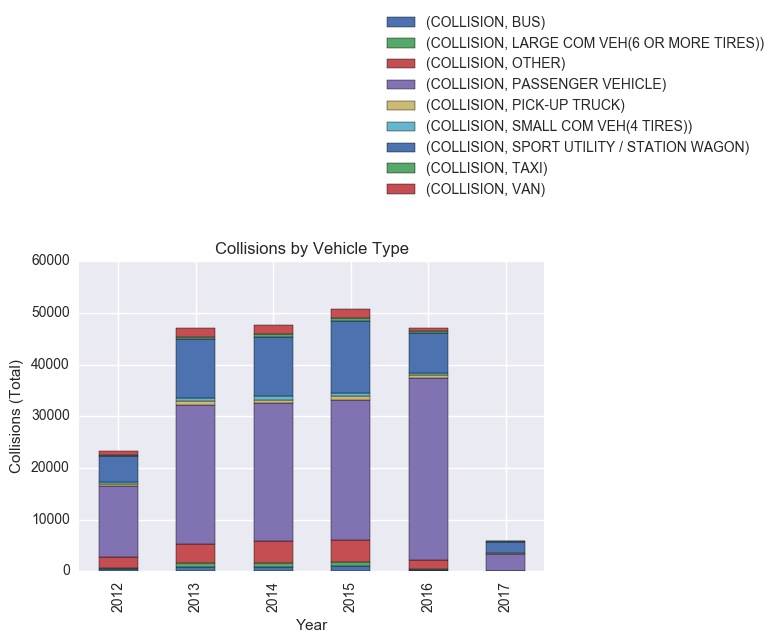

In [245]:
stacked_bar_vehicle = vehicle_grouped2.plot(kind='bar',stacked=True,title="Collisions by Vehicle Type")
stacked_bar_vehicle.set_xlabel("Year")
stacked_bar_vehicle.set_ylabel("Collisions (Total)")
stacked_bar_vehicle.legend(bbox_to_anchor=(1.5, 1.5),loc='center right')

### we can ignore 2012 and 2017 since we have only partial data for those years
### the year over year changes between 2015 and 2016 include:
###     -a big decrease in sport utility/station wagon collisions
###     -a big increase in passenger vehicle collisions
###     -an overall decrese in collisions
### One possible explanation is that there were more passenger vehicles on the road in 2016 and fewer sport utility vehicles.   The rise of ride-share services in 2016 may explain this: these services put more passenger vehicles on the road (the vehicle of choice for the majority of ride-share drivers) and can also reduce the need for car ownership.  There may have been a decrease in ownership for BOTH passenger and sport utility vehicles but, in terms of cars on the road, passenger cars may have increased while sport utility vehicles may have decreased in 2016.  It would be interesting to incorporate ownership data (eg from the DMV) to attempt to better understand this.

In [288]:
vehicle_factor = vehicle_df[['VEHICLE TYPE CODE 1','CONTRIBUTING FACTOR VEHICLE 1','COLLISION_SERIOUS']].groupby(\
['VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1']).sum()


In [289]:
vehicle_factor.unstack()

COLLISION_SERIOUS  \
CONTRIBUTING FACTOR VEHICLE 1  Accelerator Defective   
VEHICLE TYPE CODE 1                                    
BUS                                              NaN   
LARGE COM VEH(6 OR MORE TIRES)                   0.0   
OTHER                                            2.0   
PASSENGER VEHICLE                               20.0   
PICK-UP TRUCK                                    0.0   
SMALL COM VEH(4 TIRES)                           NaN   
SPORT UTILITY / STATION WAGON                    8.0   
TAXI                                             0.0   
VAN                                              0.0   

                                                             \
CONTRIBUTING FACTOR VEHICLE 1  Aggressive Driving/Road Rage   
VEHICLE TYPE CODE 1                                           
BUS                                                     1.0   
LARGE COM VEH(6 OR MORE TIRES)                          3.0   
OTHER                                                  37.0   
PASSENGER VEHICLE                                     118.0   
PICK-UP TRUCK                                           1.0   
SMALL COM VEH(4 TIRES)                                  1.0   
SPORT UTILITY / STATION WAGON                          37.0   
TAXI                                                    4.0   
VAN                                                     6.0   

                                                                   \
CONTRIBUTING FACTOR VEHICLE 1  Alcohol Involvement Animals Action   
VEHICLE TYPE CODE 1                                                 
BUS                                            2.0            NaN   
LARGE COM VEH(6 OR MORE TIRES)                 2.0            NaN   
OTHER                                         28.0            1.0   
PASSENGER VEHICLE                            304.0            7.0   
PICK-UP TRUCK                                  4.0            NaN   
SMALL COM VEH(4 TIRES)                         3.0            NaN   
SPORT UTILITY / STATION WAGON                131.0            3.0   
TAXI                                           9.0            1.0   
VAN                                           14.0            0.0   

                                                                  \
CONTRIBUTING FACTOR VEHICLE 1  Backing Unsafely Brakes Defective   
VEHICLE TYPE CODE 1                                                
BUS                                         3.0              2.0   
LARGE COM VEH(6 OR MORE TIRES)              9.0              0.0   
OTHER                                      51.0              8.0   
PASSENGER VEHICLE                         333.0             93.0   
PICK-UP TRUCK                               5.0              3.0   
SMALL COM VEH(4 TIRES)                      9.0              0.0   
SPORT UTILITY / STATION WAGON             215.0             40.0   
TAXI                                       14.0              3.0   
VAN                                        21.0              7.0   

                                                                               \
CONTRIBUTING FACTOR VEHICLE 1  Cell Phone (hand-held) Cell Phone (hands-free)   
VEHICLE TYPE CODE 1                                                             
BUS                                               0.0                     NaN   
LARGE COM VEH(6 OR MORE TIRES)                    NaN                     0.0   
OTHER                                             0.0                     1.0   
PASSENGER VEHICLE                                 2.0                    10.0   
PICK-UP TRUCK                                     NaN                     0.0   
SMALL COM VEH(4 TIRES)                            NaN                     0.0   
SPORT UTILITY / STATION WAGON                     0.0                     1.0   
TAXI                                              NaN                     NaN   
VAN                                               0.0               

###  We'll need to look at this in percentage terms (% breakdown of the factors for each vehicle)
### It probably makes sense to first bucket the less impactful factors 

In [290]:
vehicle_factor_crosstab = vehicle_factor.unstack()
vehicle_factor_crosstab.columns = vehicle_factor_crosstab.columns.droplevel()
vehicle_factor_crosstab.drop('Unspecified', inplace=True, axis=1)


In [291]:
vehicle_factor_crosstab.fillna(value=0, inplace =True) 

In [292]:
vehicle_factor_pct = vehicle_factor_crosstab.apply(lambda c: c / c.sum() * 100, axis=1)

In [293]:
vehicle_factor_pct.iloc[0].sum()

99.99999999999997

In [294]:
vehicle_factor_pct

CONTRIBUTING FACTOR VEHICLE 1,Accelerator Defective,Aggressive Driving/Road Rage,Alcohol Involvement,Animals Action,Backing Unsafely,Brakes Defective,Cell Phone (hand-held),Cell Phone (hands-free),Driver Inattention/Distraction,Driver Inexperience,Driverless/Runaway Vehicle,Drugs (Illegal),Failure to Keep Right,Failure to Yield Right-of-Way,Fatigued/Drowsy,Fell Asleep,Following Too Closely,Glare,Headlights Defective,Illness,Lane Marking Improper/Inadequate,Lost Consciousness,Obstruction/Debris,Other Electronic Device,Other Lighting Defects,Other Vehicular,Outside Car Distraction,Oversized Vehicle,Passenger Distraction,Passing or Lane Usage Improper,Pavement Defective,Pavement Slippery,Pedestrian/Bicyclist/Other Pedestrian Error/Confusion,Physical Disability,Prescription Medication,Reaction to Other Uninvolved Vehicle,Shoulders Defective/Improper,Steering Failure,Tire Failure/Inadequate,Tow Hitch Defective,Traffic Control Device Improper/Non-Working,Traffic Control Disregarded,Turning Improperly,Unsafe Lane Changing,Unsafe Speed,View Obstructed/Limited,Windshield Inadequate
VEHICLE TYPE CODE 1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BUS,0.000000,0.444444,0.888889,0.000000,1.333333,0.888889,0.000000,0.000000,24.444444,2.222222,0.000000,0.000000,0.000000,18.222222,8.444444,0.444444,1.333333,0.444444,0.000000,0.888889,0.000000,5.777778,0.444444,0.000000,0.000000,3.555556,4.444444,3.555556,5.333333,0.000000,0.444444,1.333333,0.000000,4.444444,4.000000,0.888889,0.000000,0.000000,0.000000,0.0,0.000000,1.333333,3.111111,0.000000,0.000000,1.333333,0.0
LARGE COM VEH(6 OR MORE TIRES),0.000000,1.898734,1.265823,0.000000,5.696203,0.000000,0.000000,0.000000,17.088608,2.531646,0.000000,0.000000,0.000000,11.392405,8.860759,0.632911,0.000000,0.632911,0.000000,0.000000,0.000000,6.962025,0.000000,1.265823,0.000000,4.430380,1.265823,8.227848,3.164557,0.632911,0.000000,1.265823,0.000000,5.696203,5.696203,0.000000,0.000000,0.632911,0.632911,0.0,0.000000,3.797468,4.430380,0.000000,0.632911,1.265823,0.0
OTHER,0.115075,2.128884,1.611047,0.057537,2.934407,0.460299,0.000000,0.057537,21.058688,2.301496,0.000000,0.115075,0.287687,22.497123,5.063291,0.172612,0.345224,0.287687,0.057537,0.632911,0.057537,3.222094,0.172612,0.460299,0.000000,3.337169,2.589183,0.805524,4.775604,0.747986,1.783659,1.956272,1.035673,5.235903,3.797468,0.345224,0.000000,0.172612,0.115075,0.0,0.172612,5.753740,1.495972,0.115075,0.690449,0.978136,0.0
PASSENGER VEHICLE,0.172369,1.016978,2.620012,0.060329,2.869947,0.801517,0.017237,0.086185,24.054124,2.404551,0.008618,0.206843,0.465397,19.494958,7.437732,0.396449,1.654744,1.111781,0.043092,0.568818,0.025855,2.240800,0.155132,0.508489,0.051711,3.137120,1.422046,0.198225,4.516073,0.456778,0.163751,2.154615,0.551581,5.429630,3.111264,0.465397,0.008618,0.180988,0.068948,0.0,0.180988,5.145221,1.792640,0.344738,0.775661,1.422046,0.0
PICK-UP TRUCK,0.000000,0.471698,1.886792,0.000000,2.358491,1.415094,0.000000,0.000000,31.603774,1.415094,0.000000,0.000000,0.471698,21.226415,5.660377,0.471698,4.245283,2.358491,0.000000,0.000000,0.000000,0.471698,0.000000,0.471698,0.000000,0.000000,1.415094,1.886792,4.245283,0.000000,0.000000,1.886792,0.000000,4.716981,2.830189,0.000000,0.000000,0.000000,0.471698,0.0,0.471698,3.773585,0.943396,0.471698,0.943396,1.415094,0.0
SMALL COM VEH(4 TIRES),0.000000,0.666667,2.000000,0.000000,6.000000,0.000000,0.000000,0.000000,20.666667,3.333333,0.000000,0.000000,0.666667,20.000000,6.666667,0.000000,0.666667,1.333333,0.000000,0.666667,0.000000,2.666667,0.000000,2.000000,0.000000,4.000000,2.000000,8.000000,4.666667,0.000000,0.000000,2.666667,0.000000,4.000000,2.666667,0.000000,0.000000,0.666667,0.666667,0.0,0.666667,1.333333,0.666667,0.000000,0.000000,0.666667,0.0
SPORT UTILITY / STATION WAGON,0.151057,0.698640,2.473565,0.056647,4.059668,0.755287,0.000000,0.018882,25.660876,2.020393,0.000000,0.132175,0.472054,21.015861,6.684290,0.509819,2.190332,0.925227,0.018882,0.434290,0.037764,2.039275,0.113293,0.415408,0.037764,